# HOUSE SALES IN KING COUNTY, USA

- **COMPANY:** House Rocket.


- **BUSINESS MODEL:** Buy houses at a low price and review at the highest price.


- **WHAT'S THE CHALLENGE:** Finding good deals within the available portfolio, that is, finding homes with a low price, in a great location and that have a great resale potential for a higher price.


- **DATA:** This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.


- **SOURCE:** https://www.kaggle.com/harlfoxem/housesalesprediction




# 0.0 SETUP

## 0.1 Imports

In [1]:
# Data Manipulation
import csv
#import random
import datetime
import numpy               as np
import pandas              as pd

# Exploratory Data Analyses
import seaborn             as sns
import plotly.express      as px
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

#Configurations
import warnings
warnings.filterwarnings( 'ignore' )
from IPython.display       import Image
#from IPython.core.display  import HTML

# graphic visualization
import ipywidgets          as widgets
from ipywidgets            import fixed

# data import
from geopy.geocoders       import Nominatim

from scipy                 import stats     as ss
from scipy.stats           import pointbiserialr, chi2_contingency

import pickle

#from boruta                import BorutaPy
#from tabulate              import tabulate



## 0.2 Helpers Functions

In [2]:
def descriptive_statistics(num_df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(num_df.apply(np.mean)).T
    ct2 = pd.DataFrame(num_df.apply(np.median)).T

    # Dispersion - Std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_df.apply(np.std)).T
    d2 = pd.DataFrame(num_df.apply(min)).T
    d3 = pd.DataFrame(num_df.apply(max)).T
    d4 = pd.DataFrame(num_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    return m

In [3]:
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

In [4]:
def cramer_v(x,y):

    cm = pd.crosstab( x, y).values
    n = cm.sum()
    r , k = cm.shape

    chi2 = ss.chi2_contingency ( cm )[0]
    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1) ))

In [5]:
def update_map( df, waterfront, limit ):
    
    houses = df[(df['price'] <= limit) & (df['is_waterfront'] == waterfront)][['id', 'lat', 'long','price', 'level']]
    
    fig = px.scatter_mapbox( houses, lat='lat', lon='long', color='level', size='price', 
                             color_continuous_scale = px.colors.cyclical.IceFire, size_max = 15, zoom = 10 )

    fig.update_layout( mapbox_style='open-street-map' )
    fig.update_layout( height=600, margin={'r':0, 't':0, 'l':0, 'b':0} )
    fig.show()

In [6]:
def new_map( data, limit ):
    # Filter data
    df = data[data['date'] >= limit ].copy()
    
    fig = plt.figure( figsize=(21,12) )
    specs = gridspec.GridSpec( ncols=2, nrows=2, figure=fig )
    
    ax1 = fig.add_subplot( specs[0, :] ) # First rows
    ax2 = fig.add_subplot( specs[1, 0] ) # Second Row First Column
    ax3 = fig.add_subplot( specs[1, 1] ) # Second Row Second Column rows
    
    by_year = df[['id', 'year']].groupby( 'year').sum().reset_index()
    ax1.bar( by_year['year'], by_year['id'] )
    
    by_day = df[['id', 'date']].groupby( 'date').mean().reset_index()
    ax2.plot( by_day['date'], by_day['id'] )
    ax2.set_title( 'title: Avg Price by Day' )
    
    by_week_of_year = df[['id', 'year_week']].groupby( 'year_week').mean().reset_index()
    ax3.bar( by_week_of_year['year_week'], by_week_of_year['id'] )
    ax3.set_title( 'title: Avg Price by Week Of Year' )
    plt.xticks( rotation=60 );

# 1.0 LOADING DATA

In [7]:
df1 = pd.read_csv('data/kc_house_data.csv')

In [8]:
df1

id             date     price  bedrooms  bathrooms  \
0      7129300520  20141013T000000  221900.0         3       1.00   
1      6414100192  20141209T000000  538000.0         3       2.25   
2      5631500400  20150225T000000  180000.0         2       1.00   
3      2487200875  20141209T000000  604000.0         4       3.00   
4      1954400510  20150218T000000  510000.0         3       2.00   
...           ...              ...       ...       ...        ...   
21608   263000018  20140521T000000  360000.0         3       2.50   
21609  6600060120  20150223T000000  400000.0         4       2.50   
21610  1523300141  20140623T000000  402101.0         2       0.75   
21611   291310100  20150116T000000  400000.0         3       2.50   
21612  1523300157  20141015T000000  325000.0         2       0.75   

       sqft_living  sqft_lot  floors  waterfront  view  ...  grade  \
0             1180      5650     1.0           0     0  ...      7   
1             2570      7242     2.0           0     0  ...      7   
2              770     10000     1.0           0     0  ...      6   
3             1960      5000     1.0           0     0  ...      7   
4             1680      8080     1.0           0     0  ...      8   
...            ...       ...     ...         ...   ...  ...    ...   
21608         1530      1131     3.0           0     0  ...      8   
21609         2310      5813     2.0           0     0  ...      8   
21610         1020      1350     2.0           0     0  ...      7   
21611         1600      2388     2.0           0     0  ...      8   
21612         1020      1076     2.0           0     0  ...      7   

       sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
0            1180              0      1955             0    98178  47.5112   
1            2170            400      1951          1991    98125  47.7210   
2             770              0      1933             0    98028  47.7379   
3            1050            910      1965             0    98136  47.5208   
4            1680              0      1987             0    98074  47.6168   
...           ...            ...       ...           ...      ...      ...   
21608        1530              0      2009             0    98103  47.6993   
21609        2310              0      2014             0    98146  47.5107   
21610        1020              0      2009             0    98144  47.5944   
21611        1600              0      2004             0    98027  47.5345   
21612        1020              0      2008             0    98144  47.5941   

          long  sqft_living15  sqft_lot15  
0     -122.257           1340        5650  
1     -122.319           1690        7639  
2     -122.233           2720        8062  
3     -122.393           1360        5000  
4     -122.045           1800        7503  
...        ...            ...         ...  
21608 -122.346           1530        1509  
21609 -122.362           1830        7200  
21610 -122.299           1020        2007  
21611 -122.069           1410        1287  
21612 -122.299           1020        1357  

[21613 rows x 21 columns]

# 2.0 DATA DESCRIPTION

In [9]:
df2 = df1.copy()

## 2.1 Features Description

**id =**	Identification;

**date =**	Date sold;

**price =**	Sale price;

**bedrooms =**	Number of bedrooms;

**bathrooms =**	Number of bathrooms;

**sqft_liv =**	Size of living area in square feet;

**sqft_lot =**	Size of the lot in square feet;

**floors =**	Number of floors;

**waterfront =**	'1' if the property has a waterfront, '0' if not;

**view =**	An index from 0 to 4 of how good the view of the property was;

**condition =**	Condition of the house, ranked from 1 to 5. See session 2.1.1;

**grade =**	Classification by construction quality, ranked from 1 to 13. See session 2.1.2;

**sqft_above =**	Square feet above ground;

**sqft_basmt =**	Square feet below ground;

**yr_built =**	Year built;

**yr_renov =**	Year renovated. '0' if never renovated;

**zipcode =**	5 digit zip code;

**lat =**	Latitude;

**long =**	Longitude;

**squft_liv15 =**	Average size of interior housing living space for the closest 15 houses, in square feet;

**squft_lot15 =**	Average size of land lots for the closest 15 houses, in square feet;

**Shape_leng =**	Polygon length in meters;

**Shape_Area =**	Polygon area in meters;


 **Source:** https://geodacenter.github.io/data-and-lab//KingCounty-HouseSales2015/ 

### 2.1.1 Building condition

Relative to age and grade. Coded 1-5.


**1 =** Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.


**2 =** Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.


**3 =** Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.


**4 =** Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.


**5 =** Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.


**Source:** https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

### 2.1.2 Building grade

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:


**1-3 =** Falls short of minimum building standards. Normally cabin or inferior structure.


**4 =** Generally older, low quality construction. Does not meet code.


**5 =** Low construction costs and workmanship. Small, simple design.


**6 =** Lowest grade currently meeting building code. Low quality materials and simple designs.


**7 =** Average grade of construction and design. Commonly seen in plats and older sub-divisions.


**8 =** Just above average in construction and design. Usually better materials in both the exterior and interior finish work.


**9 =** Better architectural design with extra interior and exterior design and quality.


**10 =** Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.


**11 =** Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.


**12 =** Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.


**13 =** Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.


**Source:** https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

### 2.1.3 Bathrooms

**0.25 =** A 0.25 bathroom is a bathroom that has either a sink, a shower, toilet or a bathtub.

**0.50 =** A 0.5 bathroom is a bathroom that does not contain a bath or a shower, just a toilet and sink.

**0.75 =** A 0.75 bathroom is a bathroom that has either a shower or tub with 1 sink and 1 toilet.

**1.00 =** A full bathroom (1.0) is a bathroom that contains exactly 1 sink, 1 bathtub, 1 shower and 1 toilet.

**Source:** https://www.badeloftusa.com/buying-guides/bathrooms/

## 2.2 Data Dimentions

In [10]:
print('Number of rows: {}'.format(df2.shape[0]), end = '\n\n')
print('Number of cols: {}'.format(df2.shape[1]), end = '\n\n')

Number of rows: 21613

Number of cols: 21



## 2.3 Data Types

In [11]:
df2.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## 2.4 Check NA

In [12]:
df2.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 2.5 Change Types

In [13]:
df2['date'] = pd.to_datetime(df2['date'])

In [14]:
df2.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [15]:
df2.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

## 2.6 Descriptive Statistics

In [16]:
num_attributes = df2.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df2.select_dtypes(exclude = ['int64', 'int32', 'float64'])

### 2.6.1 Numerical Attributes

In [17]:
descriptive_statistics(num_attributes)

attributes        min           max         range          mean  \
0              id 1000102.00 9900000190.00 9899000088.00 4580301520.86   
1           price   75000.00    7700000.00    7625000.00     540088.14   
2        bedrooms       0.00         33.00         33.00          3.37   
3       bathrooms       0.00          8.00          8.00          2.11   
4     sqft_living     290.00      13540.00      13250.00       2079.90   
5        sqft_lot     520.00    1651359.00    1650839.00      15106.97   
6          floors       1.00          3.50          2.50          1.49   
7      waterfront       0.00          1.00          1.00          0.01   
8            view       0.00          4.00          4.00          0.23   
9       condition       1.00          5.00          4.00          3.41   
10          grade       1.00         13.00         12.00          7.66   
11     sqft_above     290.00       9410.00       9120.00       1788.39   
12  sqft_basement       0.00       4820.00       4820.00        291.51   
13       yr_built    1900.00       2015.00        115.00       1971.01   
14   yr_renovated       0.00       2015.00       2015.00         84.40   
15        zipcode   98001.00      98199.00        198.00      98077.94   
16            lat      47.16         47.78          0.62         47.56   
17           long    -122.52       -121.31          1.20       -122.21   
18  sqft_living15     399.00       6210.00       5811.00       1986.55   
19     sqft_lot15     651.00     871200.00     870549.00      12768.46   

          median           std  skew  kurtosis  
0  3904930410.00 2876499023.43  0.24     -1.26  
1      450000.00     367118.70  4.02     34.59  
2           3.00          0.93  1.97     49.06  
3           2.25          0.77  0.51      1.28  
4        1910.00        918.42  1.47      5.24  
5        7618.00      41419.55 13.06    285.08  
6           1.50          0.54  0.62     -0.48  
7           0.00          0.09 11.39    127.63  
8           0.00          0.77  3.40     10.89  
9           3.00          0.65  1.03      0.53  
10          7.00          1.18  0.77      1.19  
11       1560.00        828.07  1.45      3.40  
12          0.00        442.56  1.58      2.72  
13       1975.00         29.37 -0.47     -0.66  
14          0.00        401.67  4.55     18.70  
15      98065.00         53.50  0.41     -0.85  
16         47.57          0.14 -0.49     -0.68  
17       -122.23          0.14  0.89      1.05  
18       1840.00        685.38  1.11      1.60  
19       7620.00      27303.55  9.51    150.76

In [18]:
# Divide features in numerical, categorical and binary
num_attributes = num_attributes.drop(columns=['waterfront'])
bin_attributes = df2['waterfront']
cat_attributes = df2.select_dtypes(exclude = ['int64', 'int32', 'float64'])

### 2.6.2 Categorical Attributes

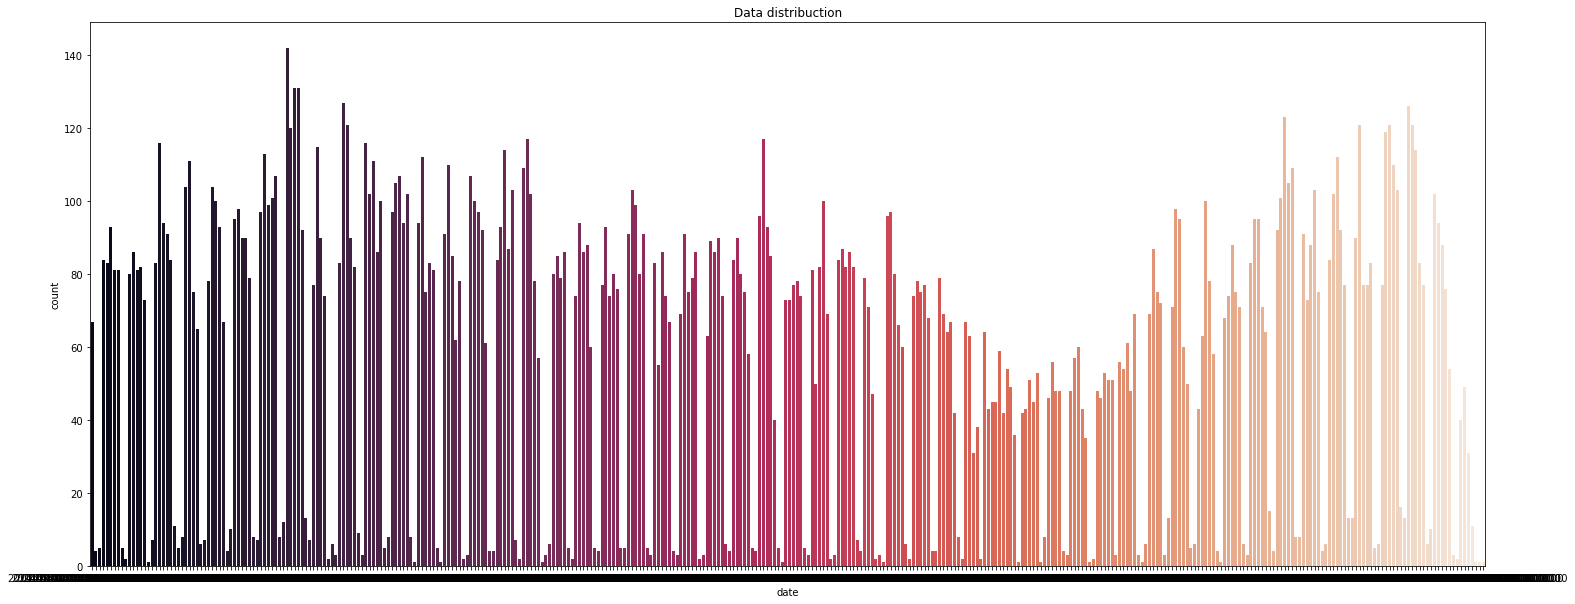

In [19]:
fig = plt.figure(figsize = (25,10))

sns.countplot(df2['date'], palette = 'rocket').set_title('Data distribuction');
#plt.xticks(rotation = 90);

# 3.0 FEATURE ENGENEERING

In [20]:
df3 = df2.copy()

## 3.1 Mind Map Hypotheses

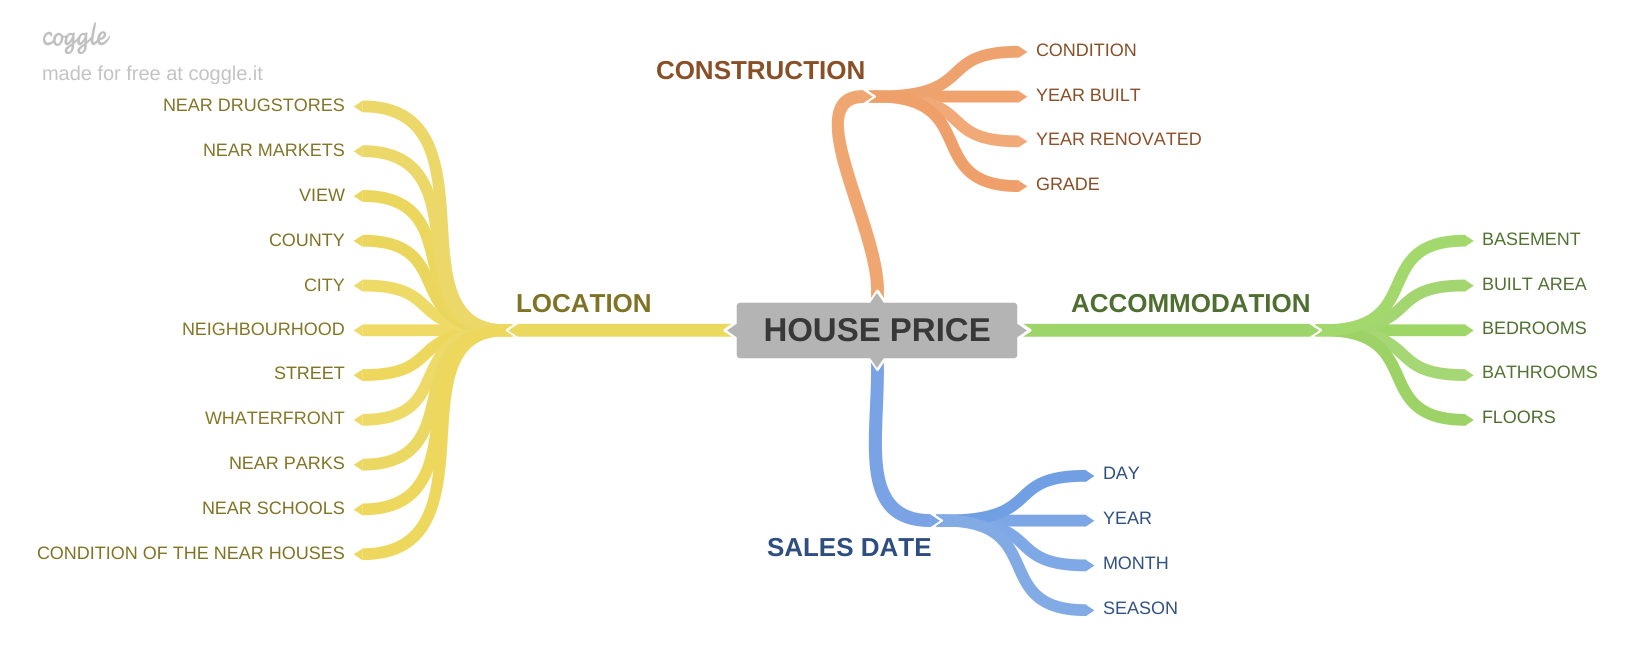

In [21]:
Image ('img/HOUSE_PRICE.png')

## 3.2 Hypotheses criation

### 3.2.1 Hypotheses Construction

**1.** Houses with higher conditions are more expensive.

**2.** Houses built after 1955 are more expensive.

**3.** Houses renovated in less time are more expensive.

**4.** Houses with higher grades are more expensives.

### 3.2.2 Hypotheses Accommodation

**5.** Houses with basement are more expensive.

**6.** Houses with higher built area are more expensive.

**7.** Houses with more bedrooms are more expensive.

**8.** Houses with more bathrooms are more expensive.

**9.** Houses with more floors are more expensive.

### 3.2.3 Hypotheses Sales Date

**10.** Houses sold in the first 15 days of the month are more expensive.

**11.** Houses sold in the first 3 months of the year are more expensive.

**12.** The year don't change the houses price.

**13.** Houses sold in high season are more expensive.

### 3.2.4 Hypotheses Location

**14.** Houses are more expensive depending on the County.

**15.** Houses are more expensive in Seattle City.

**16.** Houses are more expensive depending on the Neighbourhood.

**17.** Houses are more expensive depending on the Street.

**18.** Houses with lake view are more expensive.

**19.** Houses a better view grade are more expensive.

**20.** Houses near parks are more expensive.

**21.** Houses near schools are more expensive.

**22.** Houses near markets are more expensive.

**23.** Houses near drugstores are more expensive.

**24.** Houses near other houses with high condition grade are more expensive.

**25.** Houses near other houses with high sqft living are more expensive.

## 3.3 Hypotheses final list

**1.** Houses with higher conditions are more expensive.

**2.** Houses built after 1955 are more expensive.

**3.** Houses renovated in less time are more expensive.

**4.** Houses with higher grades are more expensives.

**5.** Houses with basement are more expensive.

**6.** Houses with higher built area are more expensive.

**7.** Houses with more bedrooms are more expensive.

**8.** Houses with more bathrooms are more expensive.

**9.** Houses with more floors are more expensive.

**10.** Houses sold in the first 15 days of the month are more expensive.

**11.** Houses sold in the first 3 months of the year are more expensive.

**12.** Houses are more expensive in Seattle City.

**13.** Houses with lake view are more expensive.

**14.** Houses a better view grade are more expensive.

**15.** Houses near other houses with high sqft living are more expensive.

**16.** Houses with high profit are more expensive.

## 3.4 Hypotheses for Future Analysis

**1.** Houses near parks are more expensive.

**2.** Houses near schools are more expensive.

**3.** Houses near markets are more expensive.

**4.** Houses near drugstores are more expensive.

**5.** Houses near other houses with high condition grade are more expensive.

## 3.5 Creating features

In [22]:
## Above BRL 540,000 -> high standard AND Below BRL 540,000 -> low standard
df3['standard'] = df3['price'].apply( lambda x: 'high standard' if x > 540000 else 'low standard')

## building level by price. From 0 to 3.
df3['level'] = df3['price'].apply( lambda x: 0 if x < 321950 else
                                               1 if 321950 <= x < 450000 else
                                               2 if 450000 <= x < 645000 else 3)
df3['level'] = df3['level'].astype(int)

## Year
df3['year'] = pd.to_datetime( df3['date'] ).dt.year

## Week
df3['year_week'] = pd.to_datetime( df3['date'] ).dt.isocalendar().week

# Month
df3['month'] = df3['date'].dt.month

# Day
df3['day'] = df3['date'].dt.day

# Price per sqft_lot:
df3['price/ft2'] = df3['price'] / df3['sqft_lot']

# Median buying price by zipcode
a = df3[['price/ft2','zipcode']].groupby('zipcode').median().reset_index().rename(columns={'price/ft2': 'median_price/ft2_zipcode'})
df3 = pd.merge(df3, a, on='zipcode', how='left')



In [23]:
# decision: buy or not buy
df3['decision'] = df3[['price/ft2', 'median_price/ft2_zipcode']].apply(lambda x: 1 if x['price/ft2'] <= x['median_price/ft2_zipcode'] else 0, axis=1)

# Sales price suggestion
df3['price_suggestion'] = df3[['sqft_lot', 'median_price/ft2_zipcode', 'condition']].apply(lambda x: (x['median_price/ft2_zipcode']*x['sqft_lot']) if (x['condition']>= 3) 
                                                                                             else ((x['median_price/ft2_zipcode']*x['sqft_lot'])*0.8), axis = 1)
# Sales profit
df3['profit'] = df3['price_suggestion'] - df3['price']

# Profitable purchase: 
df3['profitable_purchase'] = df3[['profit', 'price']].apply(lambda x: 'prejudice' if (x['profit']< 0) else 'low profit' 
                                                              if x['profit']< (x['price']*0.25) 
                                                              else 'medium profit' if  (x['price']*0.25) <= x['profit'] < (x['price']*0.5) 
                                                              else 'high profit', axis = 1)

In [24]:
df3.to_excel("output2.xlsx")

## 3.6 Adding features from API 
- The name of the street
- Property number
- The name of the neighborhood
- The name of the city
- The name of the state

In [25]:
#Inicialize Nominatim API
geolacator = Nominatim(user_agent = 'geoapiExercises')

In [26]:
response = geolacator.reverse('47.5112,-122.257')
response.raw

{'place_id': 148421265,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 236673600,
 'lat': '47.5112302',
 'lon': '-122.25676111324441',
 'display_name': '10012, 61st Avenue South, Rainier Beach, Seattle, King County, Washington, 98178, United States',
 'address': {'house_number': '10012',
  'road': '61st Avenue South',
  'neighbourhood': 'Rainier Beach',
  'city': 'Seattle',
  'county': 'King County',
  'state': 'Washington',
  'postcode': '98178',
  'country': 'United States',
  'country_code': 'us'},
 'boundingbox': ['47.511189', '47.5112943', '-122.2568571', '-122.2566651']}

In [27]:
response.raw['address']

{'house_number': '10012',
 'road': '61st Avenue South',
 'neighbourhood': 'Rainier Beach',
 'city': 'Seattle',
 'county': 'King County',
 'state': 'Washington',
 'postcode': '98178',
 'country': 'United States',
 'country_code': 'us'}

In [28]:
#Create empty rows

#df3['road'] = 'NA'
#df3['house_number'] = 'NA'
#df3['neighbourhood'] = 'NA'
#df3['city'] = 'NA'
#df3['county'] = 'NA'
#df3['state'] = 'NA'

In [29]:
#for i in range( len(df3) ):
#    print( 'Loop: {}/{}'.format(i, len(df3)))
#    # Make query
#    query = str(df3.loc[i, 'lat']) + ',' + str(df3.loc[i, 'long'])
    
#    # API request
#    response = geolacator.reverse( query )
    
#    # Populate df3
#    if 'road' in response.raw['address']:
#        df3.loc[i,'road'] = response.raw['address']['road']
        
#    if 'house_number' in response.raw['address']:
#        df3.loc[i,'house_number'] = response.raw['address']['house_number']
        
#    if 'neighbourhood' in response.raw['address']:
#        df3.loc[i,'neighbourhood'] = response.raw['address']['neighbourhood']
        
#    if 'city' in response.raw['address']:
#        df3.loc[i,'city'] = response.raw['address']['city']
        
#    if 'county' in response.raw['address']:
#        df3.loc[i,'county'] = response.raw['address']['county']
        
#    if 'state' in response.raw['address']:
#        df3.loc[i,'state'] = response.raw['address']['state']

In [30]:
#df3.to_excel("output.xlsx")  

In [31]:
df3 = pd.read_excel("output.xlsx") 

# 4.0 VARIABLE FILTERING

In [32]:
df4 = df3.copy()

In [33]:
df4.head(2)

Unnamed: 0          id       date   price  bedrooms  bathrooms  \
0           0  7129300520 2014-10-13  221900         3       1.00   
1           1  6414100192 2014-12-09  538000         3       2.25   

   sqft_living  sqft_lot  floors  waterfront  ...  decision  price_suggestion  \
0         1180      5650    1.00           0  ...         0         217112.93   
1         2570      7242    2.00           0  ...         0         435520.36   

      profit  profitable_purchase                    road  house_number  \
0   -4787.07            prejudice       61st Avenue South         10012   
1 -102479.64            prejudice  Northeast 127th Street           837   

   neighbourhood     city       county       state  
0  Rainier Beach  Seattle  King County  Washington  
1            NaN  Seattle  King County  Washington  

[2 rows x 40 columns]

## 4.1 Line Filtering

### 4.1.1 Removing Duplicates

In [34]:
df4['id'].value_counts()

795000620     3
2206700215    2
643300040     2
3333002450    2
1995200200    2
             ..
3420069065    1
7812801125    1
4364700875    1
3021059276    1
1777500160    1
Name: id, Length: 21436, dtype: int64

In [35]:
# Dropping Duplicates: here we will keep the most recent sales proposal
df4 = df4.sort_values('date', ascending=True)
df4 = df4.drop_duplicates(subset='id', keep='last')

### 4.1.2 Handling missing values

In [36]:
df4.isnull().sum()

Unnamed: 0                      0
id                              0
date                            0
price                           0
bedrooms                        0
bathrooms                       0
sqft_living                     0
sqft_lot                        0
floors                          0
waterfront                      0
view                            0
condition                       0
grade                           0
sqft_above                      0
sqft_basement                   0
yr_built                        0
yr_renovated                    0
zipcode                         0
lat                             0
long                            0
sqft_living15                   0
sqft_lot15                      0
standard                        0
level                           0
year                            0
year_week                       0
month                           0
day                             0
price/ft2                       0
median_price/f

#### 4.1.2.1 Road

In [37]:
## we will delete the lines that do not have the street name, as they represent only 0.01% of the data.

df4 = df4[df4['road'].notnull()]

#### 4.1.2.2 City

In [38]:
df4['city'].value_counts()

Seattle        7029
Bellevue       1279
Shoreline       607
Kent              5
King County       2
Name: city, dtype: int64

In [39]:
aux1 = df4[df4['city']=='King County']
aux1['zipcode']

148     98032
3403    98032
Name: zipcode, dtype: int64

Analyzing the zipcode, we found that 'King County' does not belong to that zipcode. We will change the value to "Kent".

In [40]:
df4['city'] = df4[['city']].apply(lambda x: 'Kent' if (x['city']=='King County') else x['city'], axis = 1)

In [41]:
print('unique:', df4['city'].unique())
print('NAN:', df4['city'].isna().sum())

unique: [nan 'Seattle' 'Bellevue' 'Shoreline' 'Kent']
NAN: 12296


In [42]:
# importing data to imput city names based on zip code.
# source: https://www.unitedstateszipcodes.org/wa/

df_zipcode = pd.read_excel('data/zip_code_database.xlsx')
df_zipcode.head(2)

zipcode    type primary_city acceptable_cities   unacceptable_cities state  \
0      501  UNIQUE   Holtsville               NaN  I R S Service Center    NY   
1      544  UNIQUE   Holtsville               NaN    Irs Service Center    NY   

           county area_codes world_region  latitude  longitude  
0  Suffolk County        631          NaN     40.81     -73.04  
1  Suffolk County        631          NaN     40.81     -73.04

In [43]:
df4 = pd.merge(df4, df_zipcode[['zipcode', 'primary_city']], on = 'zipcode', how='left')
df4.head()

Unnamed: 0          id       date   price  bedrooms  bathrooms  \
0       16768  5561000190 2014-05-02  437500         3       2.25   
1        9596   472000620 2014-05-02  790000         3       2.50   
2        9587  1024069009 2014-05-02  675000         5       2.50   
3       20602  7853361370 2014-05-02  555000         4       2.50   
4       11577  5056500260 2014-05-02  440000         4       2.25   

   sqft_living  sqft_lot  floors  waterfront  ...  price_suggestion  \
0         1970     35100    2.00           0  ...        1944210.49   
1         2600      4750    1.00           0  ...         614705.88   
2         2820     67518    2.00           0  ...        7629236.56   
3         3310      6500    2.00           0  ...         560243.14   
4         2160      8119    1.00           0  ...         551499.46   

      profit  profitable_purchase                      road  house_number  \
0 1506710.49          high profit    Southeast 154th Street         26069   
1 -175294.12            prejudice     34th Avenue Northwest          7506   
2 6954236.56          high profit        Southeast 32nd Way         23601   
3    5243.14           low profit  Southeast Terrace Street         35246   
4  111499.46        medium profit     Southeast 65th Street         12201   

   neighbourhood      city       county       state  primary_city  
0            NaN       NaN  King County  Washington      Issaquah  
1    Sunset Hill   Seattle  King County  Washington       Seattle  
2            NaN       NaN  King County  Washington      Issaquah  
3            NaN       NaN  King County  Washington    Snoqualmie  
4            NaN  Bellevue  King County  Washington      Bellevue  

[5 rows x 41 columns]

In [44]:
df4['city'] = df4.apply(lambda x: x['primary_city'] if pd.isnull(x['city']) else x['city'], axis=1)

#### 4.1.2.3 House number

In [45]:
# We will fill the missing values with w/n for without number
df4['house_number'].fillna('w/n', inplace=True)

df4.isna().sum().sort_values(ascending = False)[:5]

neighbourhood    14049
primary_city         0
waterfront           0
zipcode              0
yr_renovated         0
dtype: int64

## 4.2 Features Selection

In [46]:
df4['state'].value_counts()

Washington    21218
Name: state, dtype: int64

In [47]:
df4['county'].value_counts()

King County         21201
Pierce County          15
Snohomish County        2
Name: county, dtype: int64

For the column County we will remove the outliers before removing the column.

In [48]:
df4.columns

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'standard',
       'level', 'year', 'year_week', 'month', 'day', 'price/ft2',
       'median_price/ft2_zipcode', 'decision', 'price_suggestion', 'profit',
       'profitable_purchase', 'road', 'house_number', 'neighbourhood', 'city',
       'county', 'state', 'primary_city'],
      dtype='object')

In [49]:
df4 = df4.drop(['Unnamed: 0', 'neighbourhood', 'state', 'primary_city'], axis=1)

In [50]:
df4.to_csv("data/houses_sales.csv")

## 4.3 Outliers

### 4.3.1 Checking outliers

In [51]:
num_attributes = df4.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64'])

In [52]:
descriptive_statistics(num_attributes)

attributes         min           max         range  \
0                         id  1000102.00 9900000190.00 9899000088.00   
1                      price    75000.00    7700000.00    7625000.00   
2                   bedrooms        0.00         33.00         33.00   
3                  bathrooms        0.00          8.00          8.00   
4                sqft_living      290.00      13540.00      13250.00   
5                   sqft_lot      520.00    1651359.00    1650839.00   
6                     floors        1.00          3.50          2.50   
7                 waterfront        0.00          1.00          1.00   
8                       view        0.00          4.00          4.00   
9                  condition        1.00          5.00          4.00   
10                     grade        1.00         13.00         12.00   
11                sqft_above      290.00       9410.00       9120.00   
12             sqft_basement        0.00       4820.00       4820.00   
13                  yr_built     1900.00       2015.00        115.00   
14              yr_renovated        0.00       2015.00       2015.00   
15                   zipcode    98001.00      98199.00        198.00   
16                       lat       47.16         47.78          0.62   
17                      long     -122.52       -121.31          1.20   
18             sqft_living15      399.00       6210.00       5811.00   
19                sqft_lot15      651.00     871200.00     870549.00   
20                     level        0.00          3.00          3.00   
21                      year     2014.00       2015.00          1.00   
22                 year_week        1.00         52.00         51.00   
23                     month        1.00         12.00         11.00   
24                       day        1.00         31.00         30.00   
25                 price/ft2        0.16       2027.21       2027.05   
26  median_price/ft2_zipcode        9.70        285.71        276.02   
27                  decision        0.00          1.00          1.00   
28          price_suggestion    35864.40   79332410.63   79296546.23   
29                    profit -3558470.55   77334410.63   80892881.18   

            mean        median           std  skew  kurtosis  
0  4576768698.57 3904921110.00 2875912741.26  0.24     -1.26  
1      539443.35     450000.00     362679.93  3.83     30.67  
2           3.37          3.00          0.93  2.01     50.21  
3           2.11          2.25          0.77  0.51      1.28  
4        2076.05       1910.00        913.81  1.46      5.14  
5       14978.03       7604.50      40725.11 13.08    290.97  
6           1.49          1.50          0.54  0.62     -0.47  
7           0.01          0.00          0.09 11.53    131.05  
8           0.23          0.00          0.77  3.39     10.88  
9           3.41          3.00          0.65  1.03      0.51  
10          7.66          7.00          1.17  0.78      1.21  
11       1783.66       1560.00        823.63  1.45      3.41  
12        292.39          0.00        442.51  1.57      2.68  
13       1970.92       1975.00         29.37 -0.47     -0.66  
14         84.19          0.00        401.19  4.56     18.76  
15      98078.13      98065.00         53.52  0.40     -0.86  
16         47.56         47.57          0.14 -0.49     -0.68  
17       -122.21       -122.23          0.14  0.88      1.04  
18       1982.74       1840.00        681.87  1.11      1.61  
19      12671.83       7620.00      26937.73  9.65    157.43  
20          1.51          2.00          1.12 -0.01     -1.36  
21       2014.33       2014.00          0.47  0.74     -1.45  
22         26.82         26.00         13.51  0.06     -1.01  
23          6.56          6.00          3.12  0.07     -1.01  
24         15.69         16.00          8.64 -0.01     -1.20  
25         89.25         59.38         94.43  3.16     19.89  
26         74.23         60.05         52.17  1.59      2.23  
27          0.50     

**Features with high kurtosis values usually indicates outliers. Thus, we will focus on that data.**

#### 4.3.1.1 Bedrooms

In [53]:
df4['bedrooms'].value_counts()

3     9644
4     6765
2     2721
5     1562
6      259
1      193
7       37
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

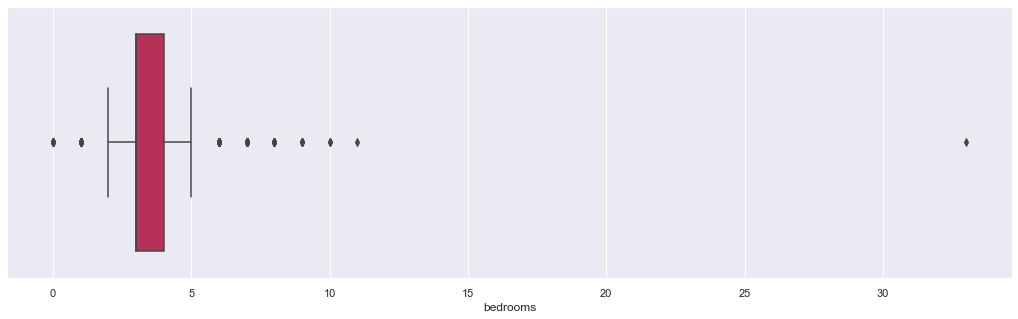

In [54]:
sns.set(rc={'figure.figsize':(18,5)})
sns.boxplot(df4['bedrooms'], palette = 'rocket');

In [55]:
df4[df4['bedrooms'] >= 10]

id       date    price  bedrooms  bathrooms  sqft_living  \
3519   2402100895 2014-06-25   640000        33       1.75         1620   
6884    627300145 2014-08-14  1148000        10       5.25         4590   
7277   1773100755 2014-08-21   520000        11       3.00         3000   
11362  5566100170 2014-10-29   650000        10       2.00         3610   
14181  8812401450 2014-12-29   660000        10       3.00         2920   

       sqft_lot  floors  waterfront  view  ...  price/ft2  \
3519       6000    1.00           0     0  ...     106.67   
6884      10920    1.00           0     2  ...     105.13   
7277       4960    2.00           0     0  ...     104.84   
11362     11914    2.00           0     0  ...      54.56   
14181      3745    2.00           0     0  ...     176.23   

       median_price/ft2_zipcode  decision  price_suggestion     profit  \
3519                     178.73         1        1072380.95  432380.95   
6884                      95.00         0        1037385.29 -110614.71   
7277                      62.70         0         310992.00 -209008.00   
11362                     67.93         1         809282.49  159282.49   
14181                    163.92         0         613898.35  -46101.65   

       profitable_purchase                    road  house_number      city  \
3519           high profit    Corliss Avenue North          8028   Seattle   
6884             prejudice   Southeast 26th Street         17079  Bellevue   
7277             prejudice  Delridge Way Southwest          5055   Seattle   
11362           low profit   Southeast 42nd Street         12353  Bellevue   
14181            prejudice    8th Avenue Northeast          4711   Seattle   

            county  
3519   King County  
6884   King County  
7277   King County  
11362  King County  
14181  King County  

[5 rows x 37 columns]

Considering that price, number of bathrooms and size of built area are incompatible with the number of bedrooms, we will consider this ad as an outlier to be removed.

#### 4.3.1.2 Lot size in square feet

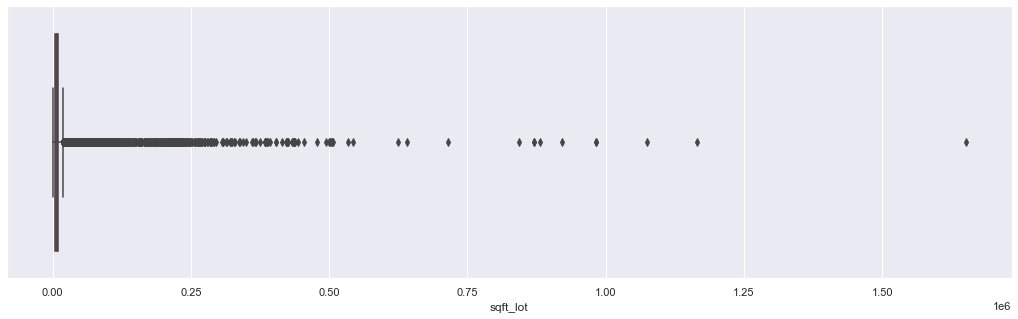

In [56]:
sns.set(rc={'figure.figsize':(18,5)})
sns.boxplot(df4['sqft_lot'], palette = 'rocket');

In [57]:
df4[df4['sqft_lot'] >= 900000.00]

id       date    price  bedrooms  bathrooms  sqft_living  \
1128   2623069031 2014-05-21   542500         5       3.25         3010   
5898   3626079040 2014-07-30   790000         2       3.00         2560   
8192    722069232 2014-09-05   998000         4       3.25         3770   
17643  2624089007 2015-03-20  1998000         2       2.50         3900   
18100  1020069017 2015-03-27   700000         4       1.00         1300   
20757  3326079016 2015-05-04   190000         2       1.00          710   

       sqft_lot  floors  waterfront  view  ...  price/ft2  \
1128    1074218    1.50           0     0  ...       0.51   
5898     982278    1.00           0     0  ...       0.80   
8192     982998    2.00           0     0  ...       1.02   
17643    920423    2.00           0     0  ...       2.17   
18100   1651359    1.00           0     3  ...       0.42   
20757   1164794    1.00           0     0  ...       0.16   

       median_price/ft2_zipcode  decision  price_suggestion      profit  \
1128                      55.39         1       59501592.57 58959092.57   
5898                      16.17         1       15884992.68 15094992.68   
8192                      35.83         1       35224095.00 34226095.00   
17643                     86.19         1       79332410.63 77334410.63   
18100                     24.44         1       40351123.41 39651123.41   
20757                     16.17         1       15069252.63 14879252.63   

       profitable_purchase                       road  house_number  \
1128           high profit     252nd Avenue Southeast         16206   
5898           high profit   Northeast Moss Lake Road           w/n   
8192           high profit      Southeast 209th Place         19115   
17643          high profit  North Fork Road Southeast           w/n   
18100          high profit     236th Avenue Southeast         41226   
20757          high profit       Kelly Road Northeast         10001   

             city       county  
1128     Issaquah  King County  
5898    Carnation  King County  
8192       Renton  King County  
17643  Snoqualmie  King County  
18100    Enumclaw  King County  
20757   Carnation  King County  

[6 rows x 37 columns]

We will remove the 3 ads with the biggest sqft_lot

#### 4.3.1.3 County

In [58]:
df4['county'].value_counts()

King County         21201
Pierce County          15
Snohomish County        2
Name: county, dtype: int64

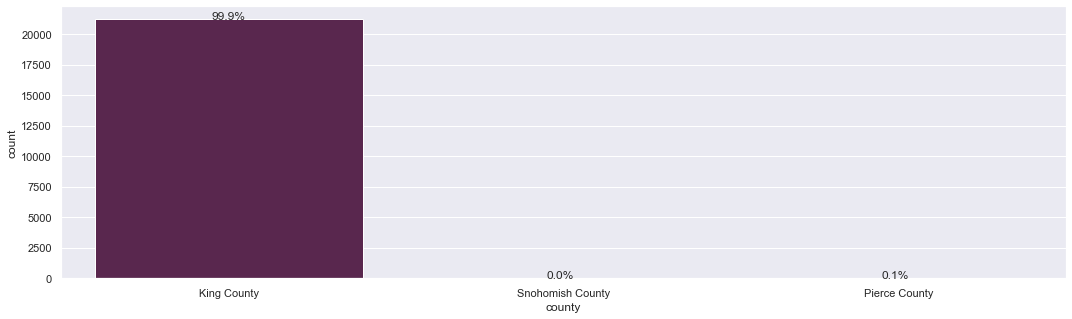

In [59]:
ax = sns.countplot(df4['county'], palette = 'rocket');
without_hue(ax, df4['county'])

### 4.3.2 Removing Outliers

In [60]:
# removing outliers: beddrooms
df_new = df4[~(df4['bedrooms'] >= 12)]

# removing outliers: Lot size in square feet
df_new = df_new[~(df_new['sqft_lot'] >= 1000000.00)]

# removing outliers: county different from King County
df_new = df_new[~(df_new['county'] != 'King County')].reset_index()

In [61]:
df_new.columns

Index(['index', 'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'standard', 'level',
       'year', 'year_week', 'month', 'day', 'price/ft2',
       'median_price/ft2_zipcode', 'decision', 'price_suggestion', 'profit',
       'profitable_purchase', 'road', 'house_number', 'city', 'county'],
      dtype='object')

In [62]:
# removing the column County:
df_new = df_new.drop(['index','county'], axis=1)

df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21197 entries, 0 to 21196
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        21197 non-null  int64         
 1   date                      21197 non-null  datetime64[ns]
 2   price                     21197 non-null  int64         
 3   bedrooms                  21197 non-null  int64         
 4   bathrooms                 21197 non-null  float64       
 5   sqft_living               21197 non-null  int64         
 6   sqft_lot                  21197 non-null  int64         
 7   floors                    21197 non-null  float64       
 8   waterfront                21197 non-null  int64         
 9   view                      21197 non-null  int64         
 10  condition                 21197 non-null  int64         
 11  grade                     21197 non-null  int64         
 12  sqft_above        

In [63]:
ratio_of_outliers_removed = 100 - (df_new.shape[0] / df4.shape[0]) * 100
print(f'Ratio of removed outliers: {round(ratio_of_outliers_removed, 2)}%')

Ratio of removed outliers: 0.1%


# 5.0 EXPLORATORY DATA ANALYSIS

In [64]:
df5 = df_new.copy()

In [65]:
df5.head()

id       date   price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  5561000190 2014-05-02  437500         3       2.25         1970     35100   
1   472000620 2014-05-02  790000         3       2.50         2600      4750   
2  1024069009 2014-05-02  675000         5       2.50         2820     67518   
3  7853361370 2014-05-02  555000         4       2.50         3310      6500   
4  5056500260 2014-05-02  440000         4       2.25         2160      8119   

   floors  waterfront  view  ...  day  price/ft2  median_price/ft2_zipcode  \
0    2.00           0     0  ...    2      12.46                     55.39   
1    1.00           0     0  ...    2     166.32                    129.41   
2    2.00           0     0  ...    2      10.00                    113.00   
3    2.00           0     0  ...    2      85.38                     86.19   
4    1.00           0     0  ...    2      54.19                     67.93   

   decision  price_suggestion     profit  profitable_purchase  \
0         1        1944210.49 1506710.49          high profit   
1         0         614705.88 -175294.12            prejudice   
2         1        7629236.56 6954236.56          high profit   
3         1         560243.14    5243.14           low profit   
4         1         551499.46  111499.46        medium profit   

                       road  house_number        city  
0    Southeast 154th Street         26069    Issaquah  
1     34th Avenue Northwest          7506     Seattle  
2        Southeast 32nd Way         23601    Issaquah  
3  Southeast Terrace Street         35246  Snoqualmie  
4     Southeast 65th Street         12201    Bellevue  

[5 rows x 36 columns]

In [66]:
df5.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'standard', 'level',
       'year', 'year_week', 'month', 'day', 'price/ft2',
       'median_price/ft2_zipcode', 'decision', 'price_suggestion', 'profit',
       'profitable_purchase', 'road', 'house_number', 'city'],
      dtype='object')

## 5.1 Univariate Analysis

In [67]:
num_attributes = df5.select_dtypes(include = ['int64', 'int32', 'float64'])
num_attributes = num_attributes.drop(columns=['waterfront', 'id', 'decision'])

bin_attributes = df5[['waterfront', 'decision']]

cat_attributes = df5.select_dtypes(exclude = ['int64', 'int32', 'float64'])
cat_attributes = cat_attributes.drop(columns=['date', 'road', 'house_number'])

### 5.1.1 Response Variable

<AxesSubplot:xlabel='price'>

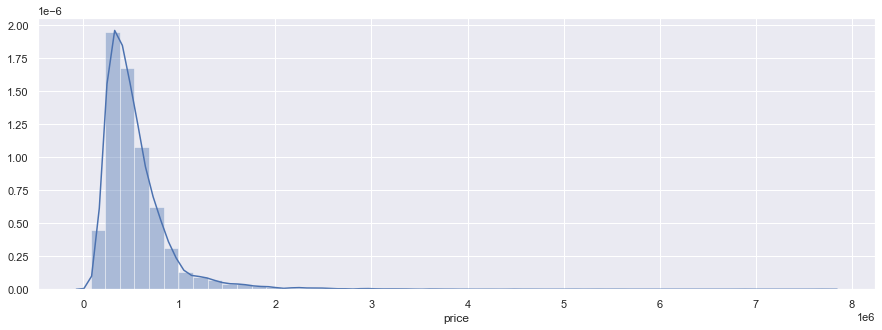

In [68]:
plt.figure(figsize = (15, 5))
sns.distplot(df5['price'])

### 5.1.2 Numerical Variable

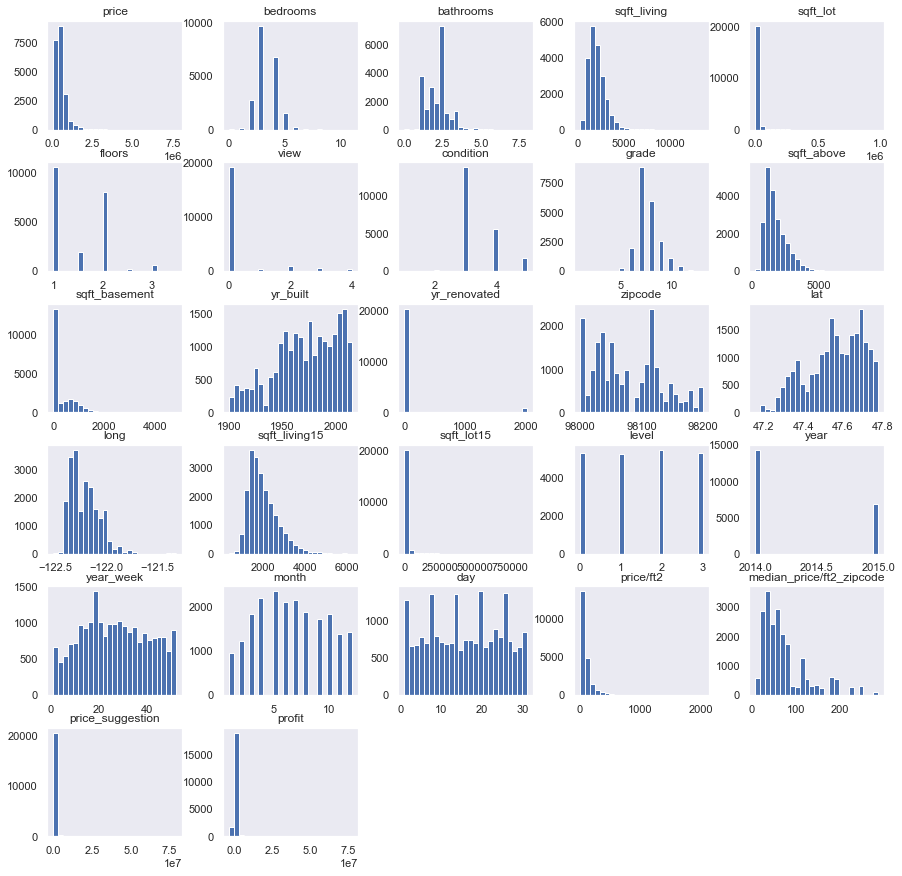

In [69]:
fig = plt.figure(figsize = (15,15))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);

In [70]:
descriptive_statistics(num_attributes)

attributes         min         max       range      mean  \
0                      price    75000.00  7700000.00  7625000.00 539630.80   
1                   bedrooms        0.00       11.00       11.00      3.37   
2                  bathrooms        0.00        8.00        8.00      2.11   
3                sqft_living      290.00    13540.00    13250.00   2076.16   
4                   sqft_lot      520.00   982998.00   982478.00  14800.62   
5                     floors        1.00        3.50        2.50      1.49   
6                       view        0.00        4.00        4.00      0.23   
7                  condition        1.00        5.00        4.00      3.41   
8                      grade        1.00       13.00       12.00      7.66   
9                 sqft_above      290.00     9410.00     9120.00   1783.64   
10             sqft_basement        0.00     4820.00     4820.00    292.53   
11                  yr_built     1900.00     2015.00      115.00   1970.92   
12              yr_renovated        0.00     2015.00     2015.00     84.27   
13                   zipcode    98001.00    98199.00      198.00  98078.16   
14                       lat       47.16       47.78        0.62     47.56   
15                      long     -122.52     -121.31        1.20   -122.21   
16             sqft_living15      399.00     6210.00     5811.00   1982.76   
17                sqft_lot15      651.00   871200.00   870549.00  12652.71   
18                     level        0.00        3.00        3.00      1.51   
19                      year     2014.00     2015.00        1.00   2014.33   
20                 year_week        1.00       52.00       51.00     26.82   
21                     month        1.00       12.00       11.00      6.56   
22                       day        1.00       31.00       30.00     15.69   
23                 price/ft2        0.59     2027.21     2026.62     89.31   
24  median_price/ft2_zipcode        9.70      285.71      276.02     74.26   
25          price_suggestion    35864.40 79332410.63 79296546.23 756943.32   
26                    profit -3558470.55 77334410.63 80892881.18 217312.52   

      median        std  skew  kurtosis  
0  450000.00  362785.71  3.83     30.66  
1       3.00       0.91  0.52      1.87  
2       2.25       0.77  0.51      1.28  
3    1910.00     913.94  1.46      5.14  
4    7600.00   37662.73 10.30    160.81  
5       1.50       0.54  0.62     -0.47  
6       0.00       0.77  3.39     10.87  
7       3.00       0.65  1.03      0.51  
8       7.00       1.17  0.78      1.21  
9    1560.00     823.67  1.45      3.41  
10      0.00     442.63  1.57      2.68  
11   1975.00      29.37 -0.47     -0.66  
12      0.00     401.38  4.55     18.74  
13  98065.00      53.51  0.40     -0.86  
14     47.57       0.14 -0.49     -0.68  
15   -122.23       0.14  0.88      1.03  
16   1840.00     682.00  1.11      1.61  
17   7620.00   26798.37  9.64    158.33  
18      2.00       1.12 -0.01     -1.36  
19   2014.00       0.47  0.74     -1.45  
20     26.00      13.51  0.06     -1.01  
21      6.00       3.12  0.07     -1.01  
22     16.00       8.64 -0.00     -1.20  
23     59.44      94.46  3.16     19.88  
24     60.05      52.18  1.58      2.23  
25 457654.83 1520554.58 14.38    440.28  
26   -612.38 1477460.50 14.81    458.99

### 5.1.3 Categorical Variable

In [71]:
cat_attributes

standard profitable_purchase        city
0       low standard         high profit    Issaquah
1      high standard           prejudice     Seattle
2      high standard         high profit    Issaquah
3      high standard          low profit  Snoqualmie
4       low standard       medium profit    Bellevue
...              ...                 ...         ...
21192   low standard          low profit     Seattle
21193   low standard           prejudice     Seattle
21194   low standard          low profit    Bellevue
21195   low standard         high profit     Seattle
21196  high standard           prejudice     Seattle

[21197 rows x 3 columns]

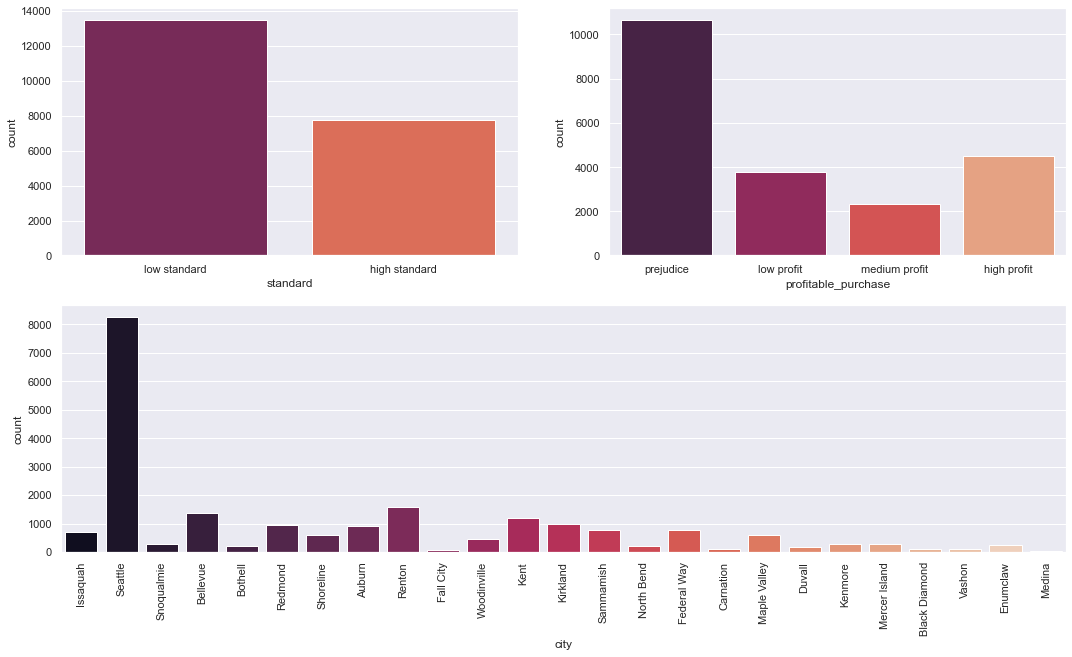

In [72]:
fig = plt.figure(figsize = (18,10))
grid = gridspec.GridSpec(2,2)

# gender
plt.subplot (grid[0,0])
sns.countplot(df4['standard'], palette = 'rocket');

# vehicle_age
plt.subplot (grid[0,1])
sns.countplot(df4['profitable_purchase'], order = ['prejudice', 'low profit', 'medium profit', 'high profit'], palette = 'rocket');

# vehicle_damage
plt.subplot (grid[1,:])
sns.countplot(df4['city'], palette = 'rocket');
plt.xticks(rotation = 90);

### 5.1.4 Binary Variable

<AxesSubplot:xlabel='waterfront', ylabel='count'>

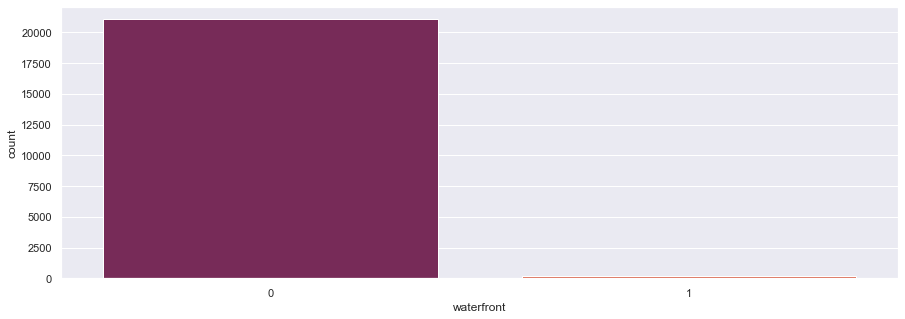

In [73]:
plt.figure(figsize = (15, 5))
sns.countplot(x='waterfront', data = df5, palette = 'rocket')

<AxesSubplot:xlabel='decision', ylabel='count'>

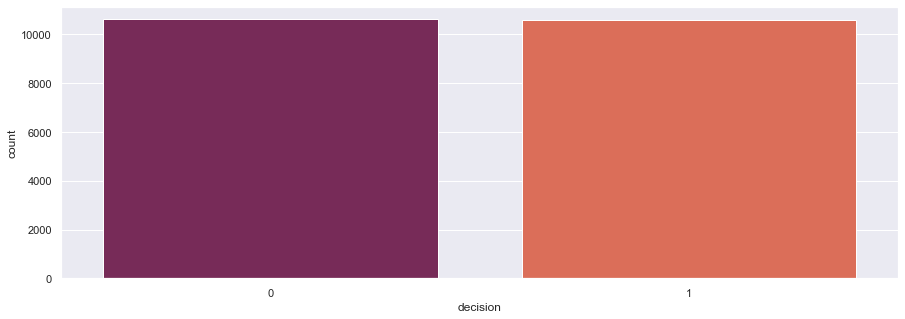

In [74]:
plt.figure(figsize = (15, 5))
sns.countplot(x='decision', data = df5, palette = 'rocket')

## 5.2 Bivariate Analysis

In [75]:
df5.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'standard', 'level',
       'year', 'year_week', 'month', 'day', 'price/ft2',
       'median_price/ft2_zipcode', 'decision', 'price_suggestion', 'profit',
       'profitable_purchase', 'road', 'house_number', 'city'],
      dtype='object')

### H1: Houses with higher conditions are more expensive.
**TRUE.** Houses with conditions higher then 3 are more expensive.

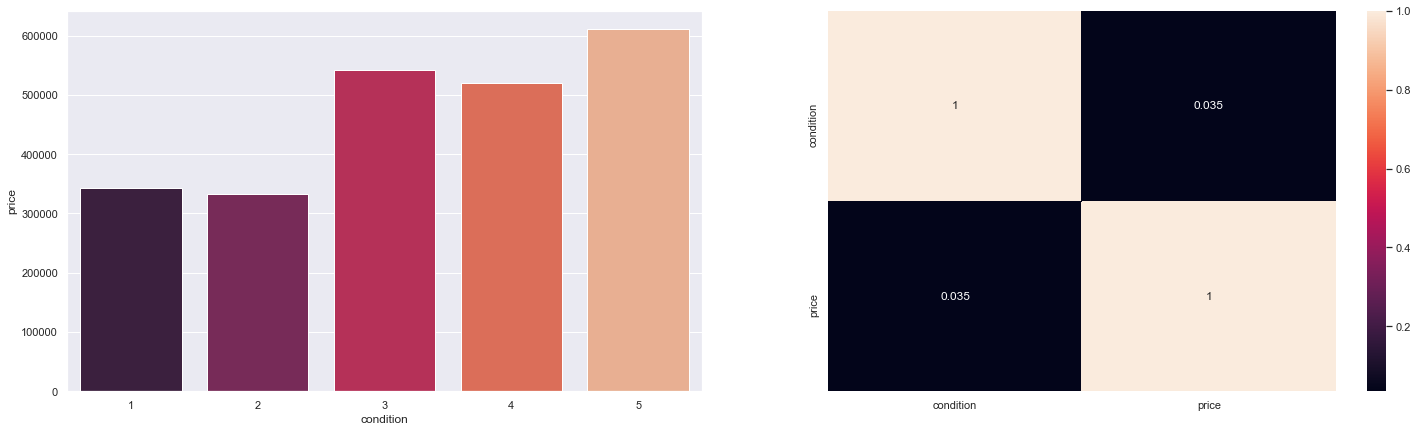

In [76]:
sns.set(rc={'figure.figsize':(25,7)})
plt.subplot (1,2,1)
aux1 = df5[['condition', 'price']].groupby('condition').mean().reset_index()
sns.barplot (x = 'condition', y = 'price', data = aux1, palette = 'rocket');

aux2 = df5[['condition', 'price']]
plt.subplot (1,2,2)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="rocket");

### H2: Houses built after 1955 are more expensive.
**FALSE.** Houses built after 1955 do not show a significant difference in value compared to homes built before 1955.

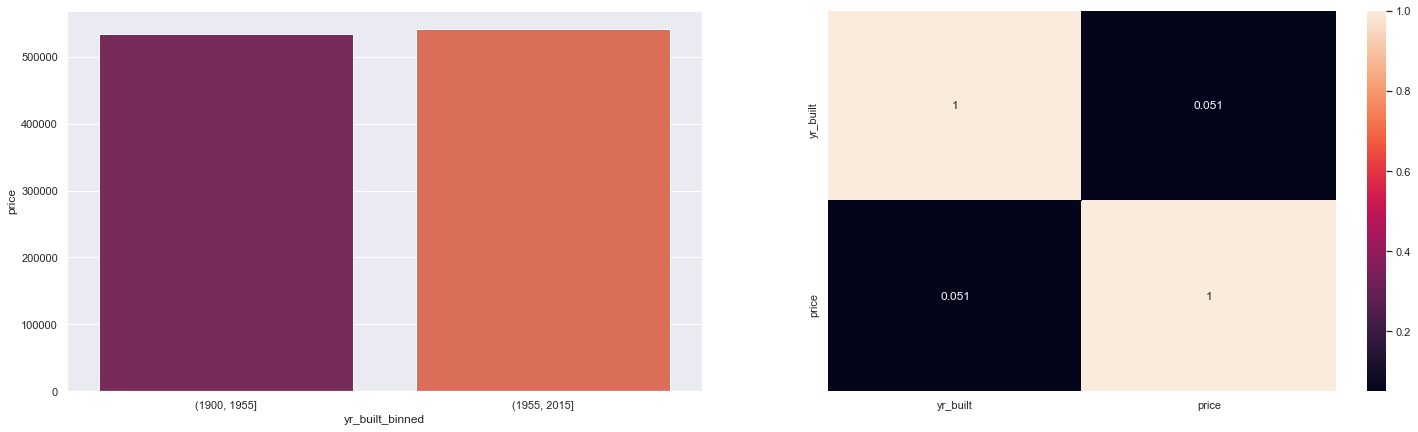

In [77]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot (1,2,1)

list=[1900,1955, 2015]
bins = list

aux1 = df5[['yr_built', 'price']]
aux1['yr_built_binned'] = pd.cut( aux1['yr_built'], bins = bins )

aux2 = aux1[['yr_built_binned','price']].groupby( 'yr_built_binned').mean().reset_index()
sns.barplot ( x = 'yr_built_binned',y ='price' , data= aux2,palette = 'rocket');

plt.subplot (1,2,2)
sns.heatmap(aux1.corr(method= 'pearson'), annot = True, cmap="rocket");

### H3: Houses renovated in less time are more expensive.
**TRUE.** Houses renovated in less time are slightly more expensive.

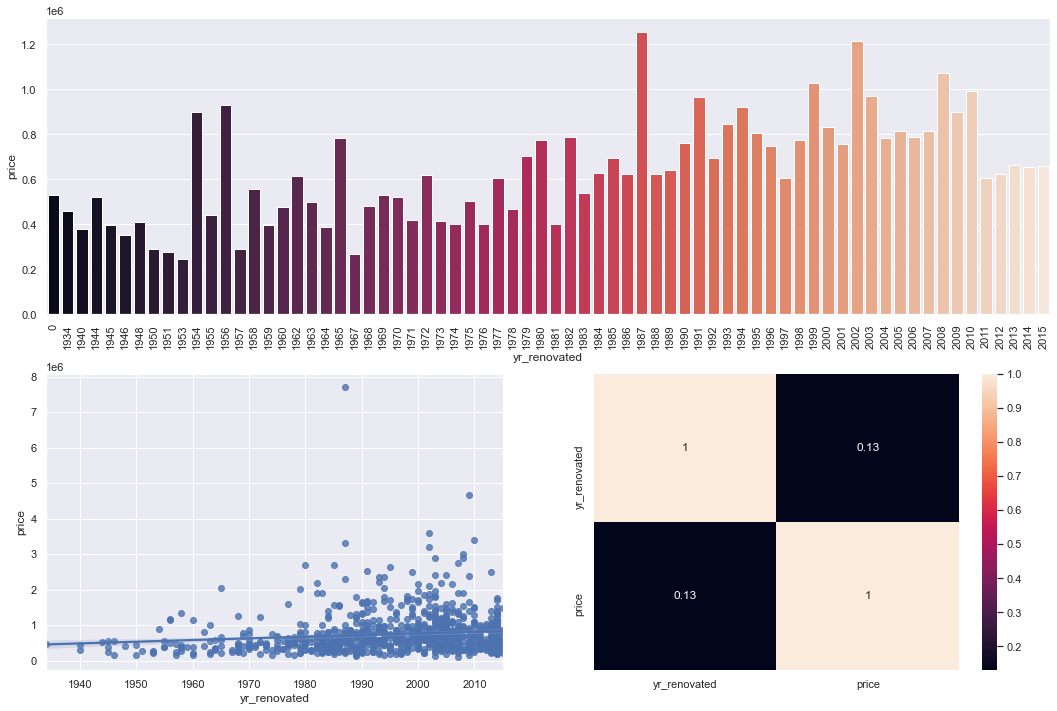

In [78]:
fig = plt.figure(figsize = (18,12))
grid = gridspec.GridSpec(2,2)

plt.subplot (grid[0,:])
aux1 = df5[['yr_renovated', 'price']].groupby('yr_renovated').mean().reset_index()
sns.barplot (x = 'yr_renovated', y = 'price', data = aux1, palette = 'rocket');
plt.xticks(rotation = 90);

plt.subplot (grid[1,0])
aux2 = df5[df5['yr_renovated'] > 0][['yr_renovated', 'price']]
sns.regplot(x = 'yr_renovated', y = 'price', data = aux2);

plt.subplot (grid[1,1])
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="rocket");

### H4: Houses with higher grades are more expensives.
**TRUE.**


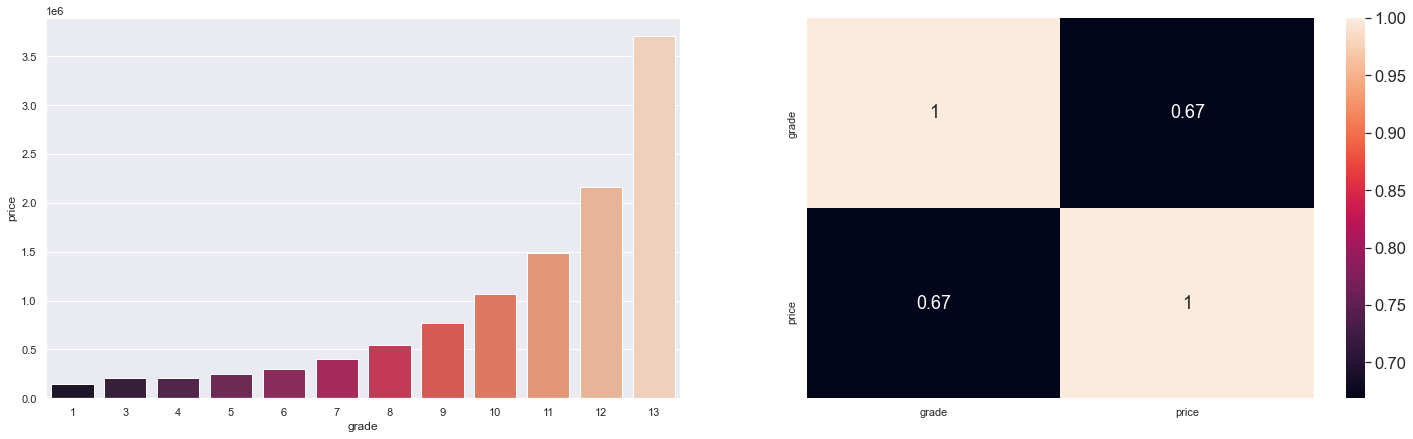

In [79]:
sns.set(rc={'figure.figsize':(25,7)})
plt.subplot (1,2,1)
aux1 = df5[['grade', 'price']].groupby('grade').mean().reset_index()
sns.barplot (x = 'grade', y = 'price', data = aux1, palette = 'rocket');

aux2 = df5[['grade', 'price']]
plt.subplot (1,2,2)
sns.set(font_scale = 1.5)
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="rocket");

### H5: Houses with basement are more expensive.
**TRUE.** Houses with basement are more expensive.


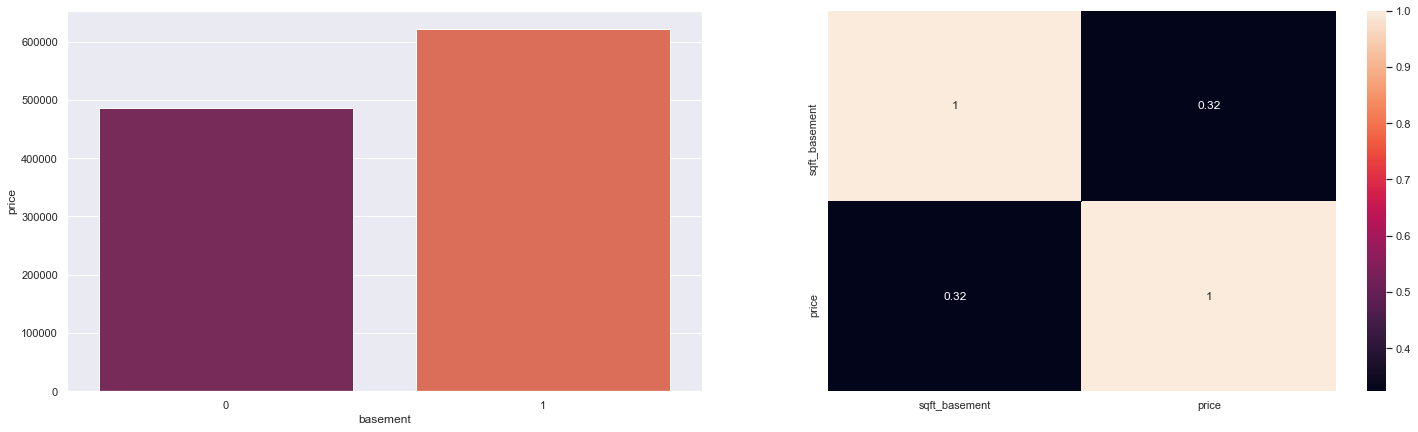

In [80]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot (1,2,1)
aux1 = df5[['sqft_basement', 'price']]
aux1['basement'] = aux1['sqft_basement'].apply( lambda x: 1 if x > 0 else 0)
aux2 = aux1[['basement', 'price']].groupby('basement').mean().reset_index()
sns.barplot (x = 'basement', y = 'price', data = aux2, palette = 'rocket');

plt.subplot (1,2,2)
aux3 = df5[['sqft_basement', 'price']]
sns.heatmap(aux3.corr(method= 'pearson'), annot = True, cmap="rocket");

### H6: Houses with higher built area are more expensive.
**TRUE.** Houses with higher built area are more expensive.

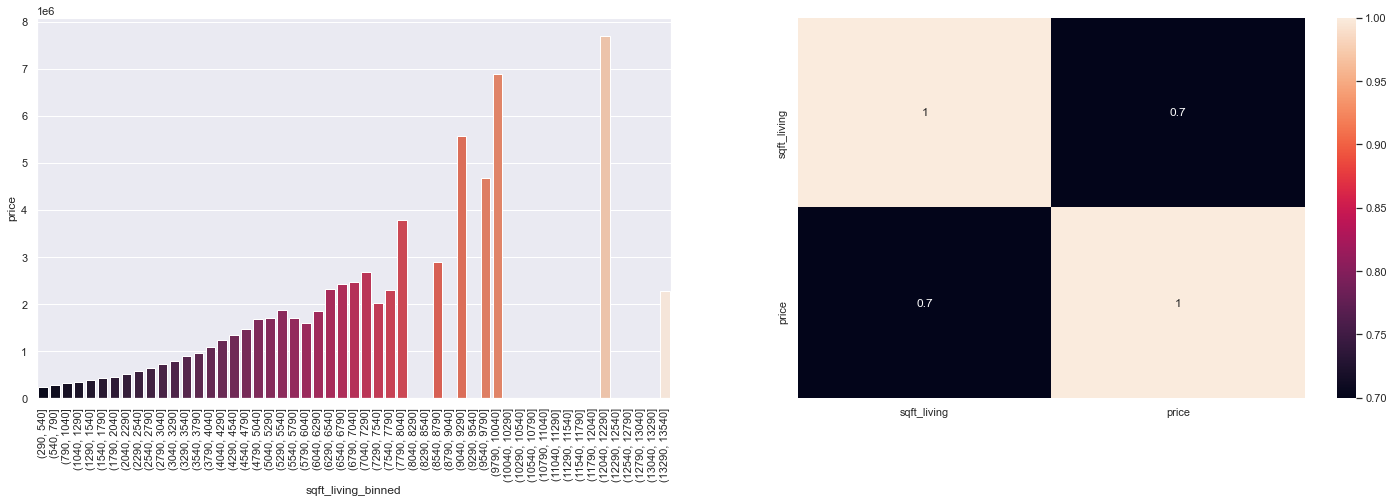

In [81]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot (1,2,1)
aux1 = df5[['sqft_living', 'price']]

bins = np.arange(290, 13550, 250)
aux1['sqft_living_binned'] = pd.cut (aux1['sqft_living'], bins = bins)
aux2 = aux1[['sqft_living_binned', 'price']].groupby('sqft_living_binned').mean().reset_index()
sns.barplot (x = 'sqft_living_binned', y = 'price', data = aux2, palette = 'rocket');
plt.xticks(rotation = 90);


plt.subplot (1,2,2)
aux3 = df5[['sqft_living', 'price']]
sns.heatmap(aux3.corr(method= 'pearson'), annot = True, cmap="rocket");

### H7: Houses with more bedrooms are more expensive.
**FALSE.** After 8 bedrooms per house, the price decreases.

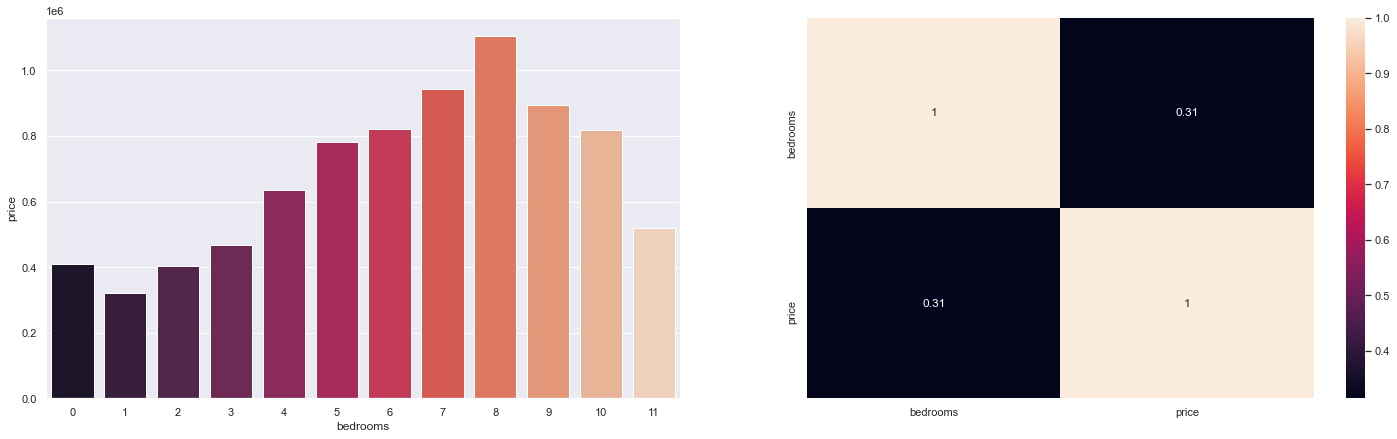

In [82]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot (1,2,1)
aux1 = df5[['bedrooms', 'price']].groupby('bedrooms').mean().reset_index()
sns.barplot (x = 'bedrooms', y = 'price', data = aux1, palette = 'rocket');

plt.subplot (1,2,2)
aux2 = df5[['bedrooms', 'price']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="rocket");

### H8: Houses with more bathrooms are more expensive.
**TRUE.** Houses with more bathrooms are more expensive.


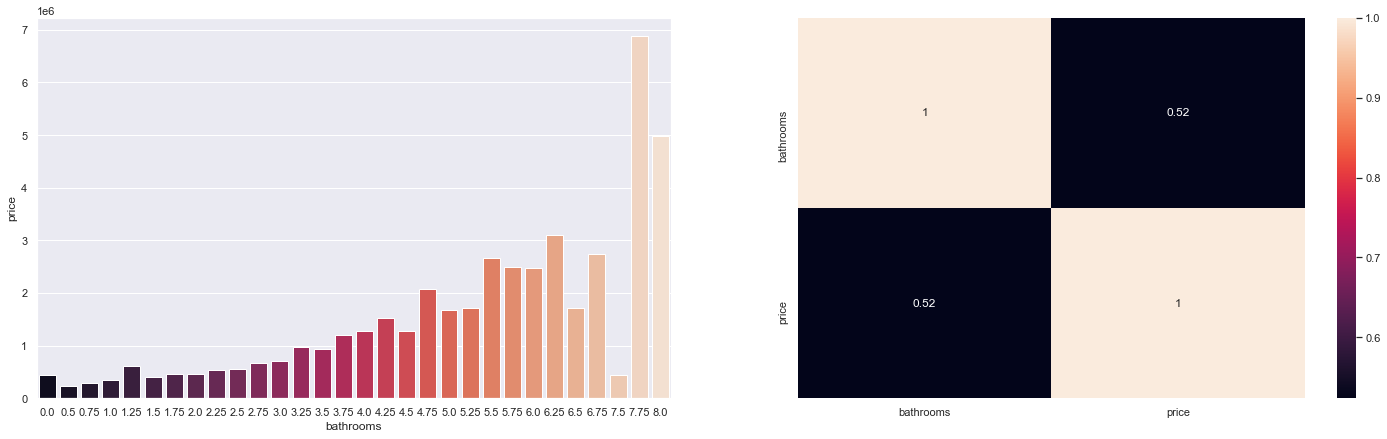

In [83]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot (1,2,1)
aux1 = df5[['bathrooms', 'price']].groupby('bathrooms').mean().reset_index()
sns.barplot (x = 'bathrooms', y = 'price', data = aux1, palette = 'rocket');

plt.subplot (1,2,2)
aux2 = df5[['bathrooms', 'price']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="rocket");

### H9: Houses with more floors are more expensive.
**TRUE.**


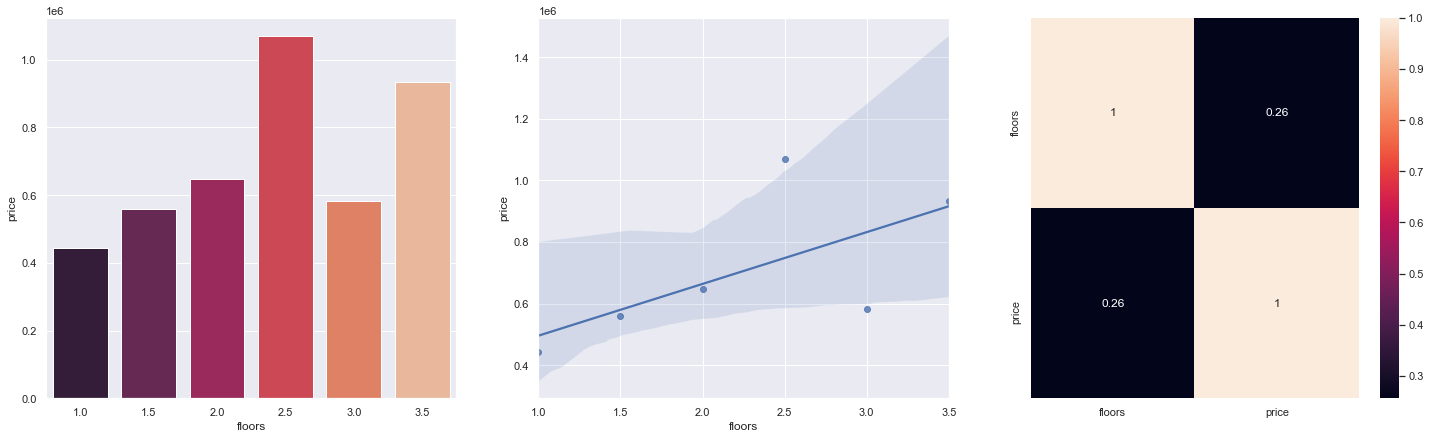

In [84]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot (1,3,1)
aux1 = df5[['floors', 'price']].groupby('floors').mean().reset_index()
sns.barplot (x = 'floors', y = 'price', data = aux1, palette = 'rocket');

plt.subplot (1,3,2)
sns.regplot(x = 'floors', y = 'price', data = aux1);

plt.subplot (1,3,3)
aux2 = df5[['floors', 'price']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="rocket");

### H10: Houses sold in the first 15 days of the month are more expensive.
**FALSE.** There is no relationship between the day of sale and the value of the house.


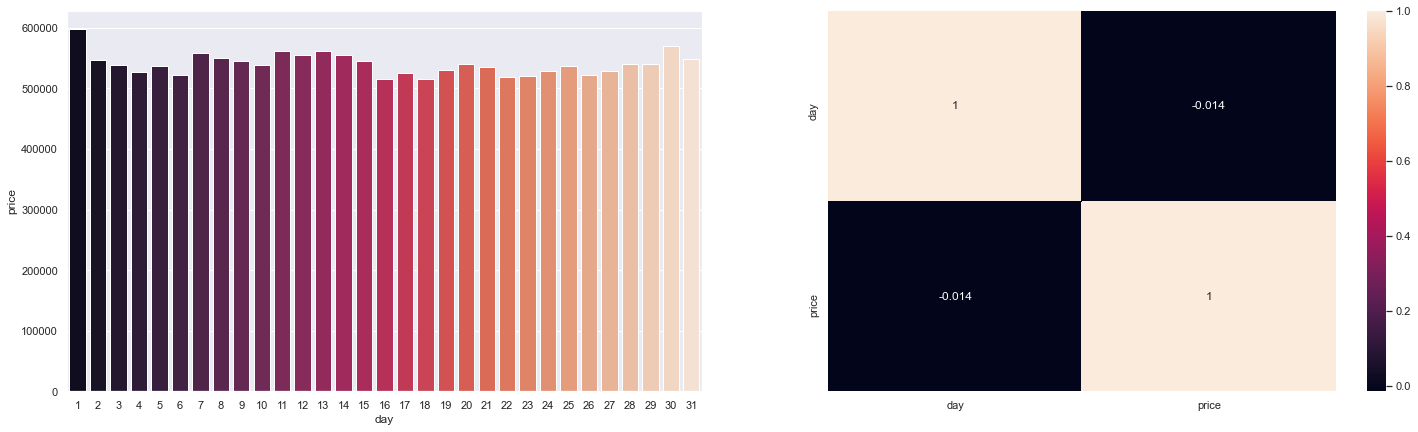

In [85]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot (1,2,1)
aux1 = df5[['day', 'price']].groupby('day').mean().reset_index()
sns.barplot (x = 'day', y = 'price', data = aux1, palette = 'rocket');

plt.subplot (1,2,2)
aux2 = df5[['day', 'price']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="rocket");

### H11: Houses sold in the first 3 months of the year are more expensive.
**FALSE.** There is no relationship between the month of sale and the value of the house.


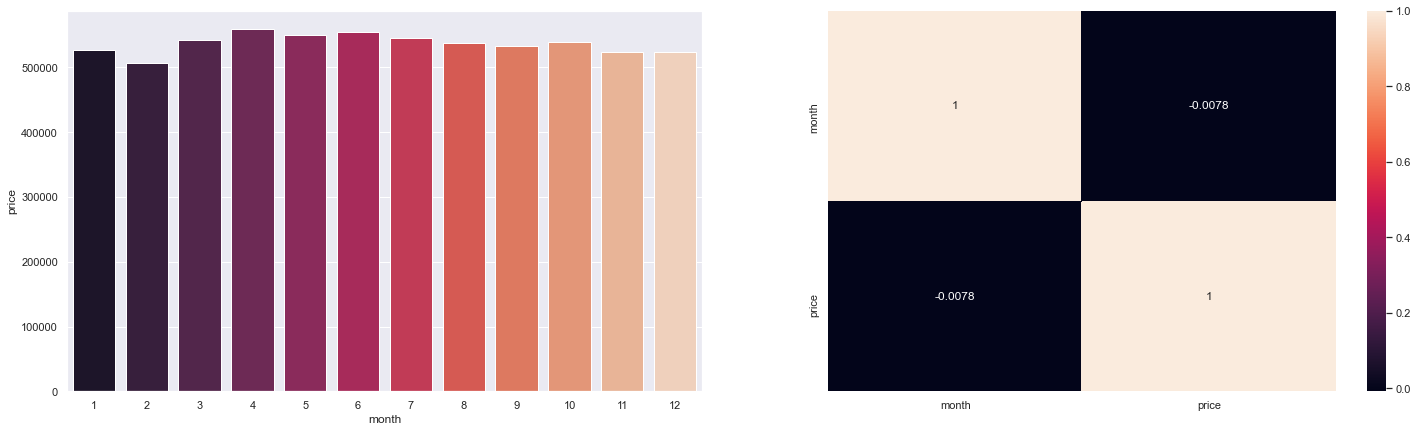

In [86]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot (1,2,1)
aux1 = df5[['month', 'price']].groupby('month').mean().reset_index()
sns.barplot (x = 'month', y = 'price', data = aux1, palette = 'rocket');

plt.subplot (1,2,2)
aux2 = df5[['month', 'price']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="rocket");

### H12: Houses are more expensive in Seattle City.
**FALSE.** Houses in Medina are more expensives.

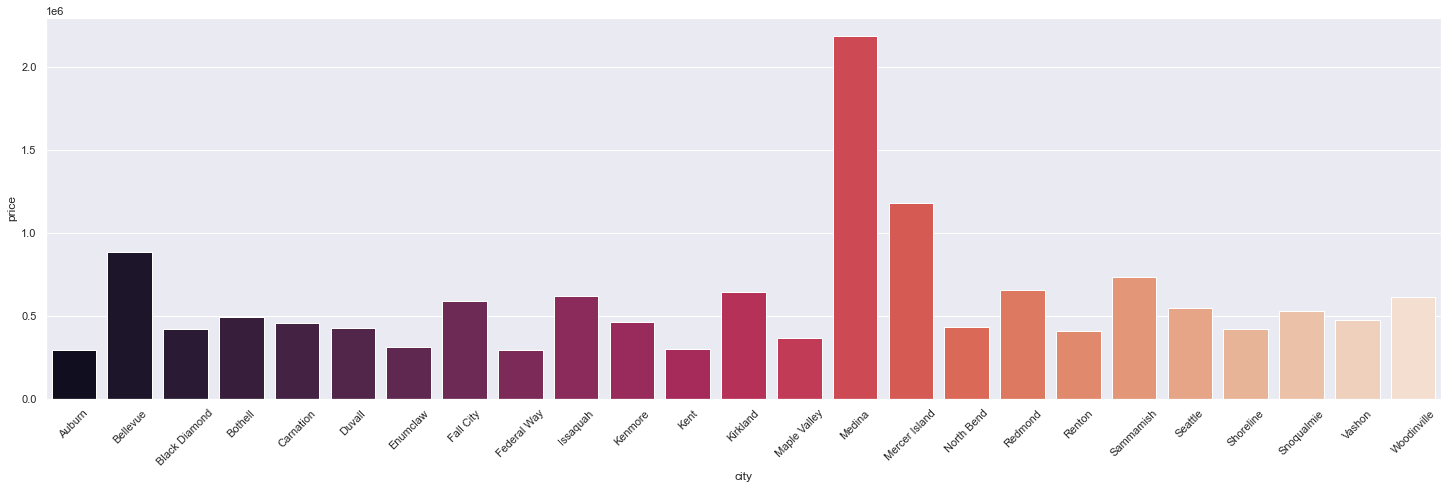

In [87]:
sns.set(rc={'figure.figsize':(25,7)})

aux1 = df5[['city', 'price']].groupby('city').mean().reset_index()
sns.barplot (x = 'city', y = 'price', data = aux1, palette = 'rocket');
plt.xticks(rotation = 45);

### H13: Houses with lake view are more expensive.
**TRUE.** House with waterfront are 3 times more expensive.

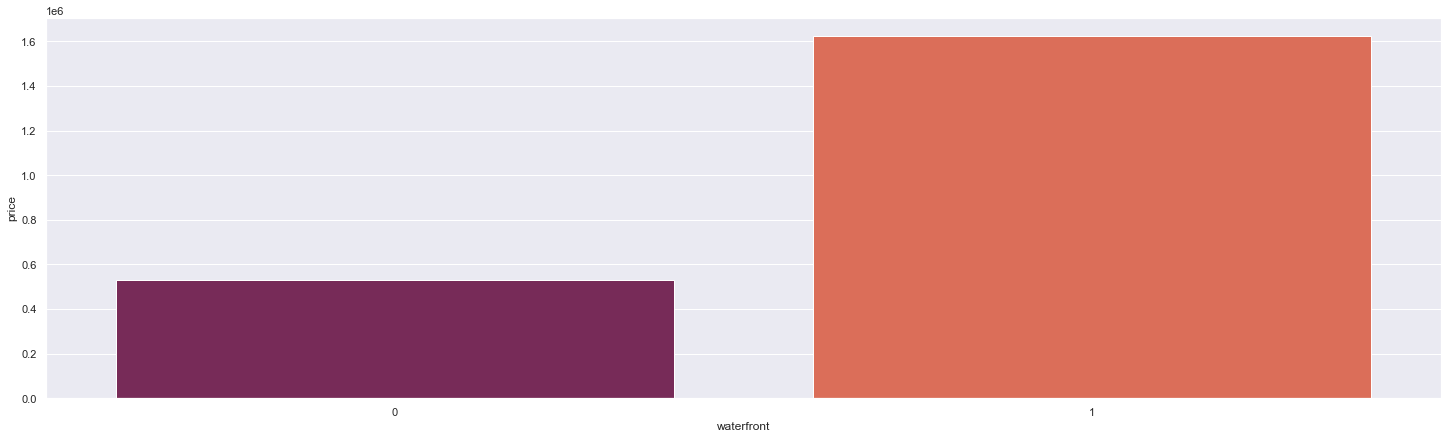

In [88]:
sns.set(rc={'figure.figsize':(25,7)})

aux1 = df5[['waterfront', 'price']].groupby('waterfront').mean().reset_index()
sns.barplot (x = 'waterfront', y = 'price', data = aux1, palette = 'rocket');

In [89]:
aux1

waterfront      price
0           0  531589.79
1           1 1624187.77

In [90]:
ratio_of_waterfront = aux1[aux1['waterfront']==1]['price'].sum() / aux1[aux1['waterfront']==0]['price'].sum()
print(f'House with waterfront are: {round(ratio_of_waterfront, 2)} times more expensive.');

House with waterfront are: 3.06 times more expensive.


### H14: Houses a better view grade are more expensive.
**TRUE.** Houses a better view grade are more expensive.


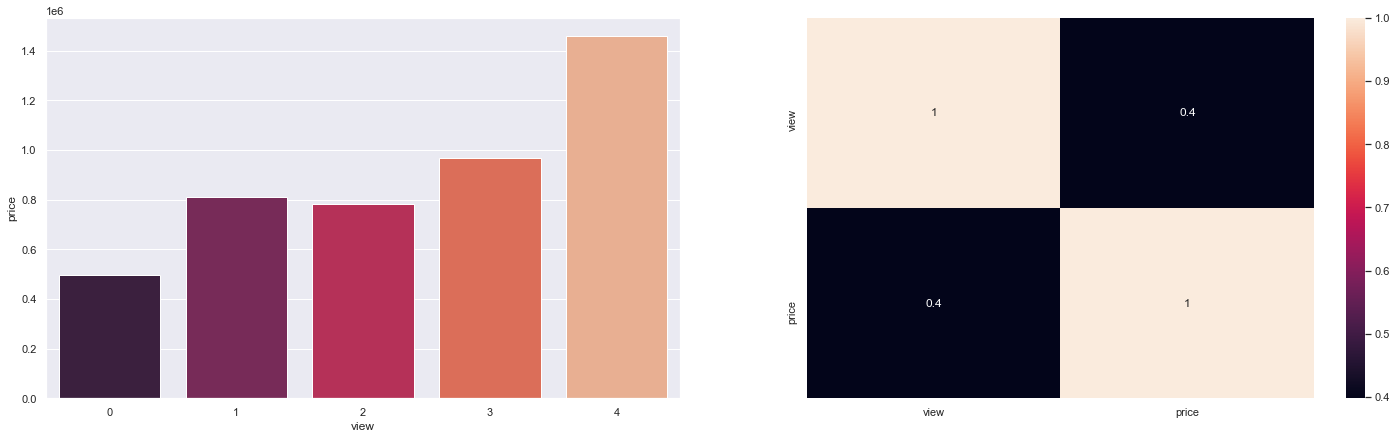

In [91]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot (1,2,1)
aux1 = df5[['view', 'price']].groupby('view').mean().reset_index()
sns.barplot (x = 'view', y = 'price', data = aux1, palette = 'rocket');

plt.subplot (1,2,2)
aux2 = df5[['view', 'price']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True, cmap="rocket");

### H15: Houses near other houses with high sqft living are more expensive.
**TRUE.** Houses near other houses with high sqft living are more expensive.

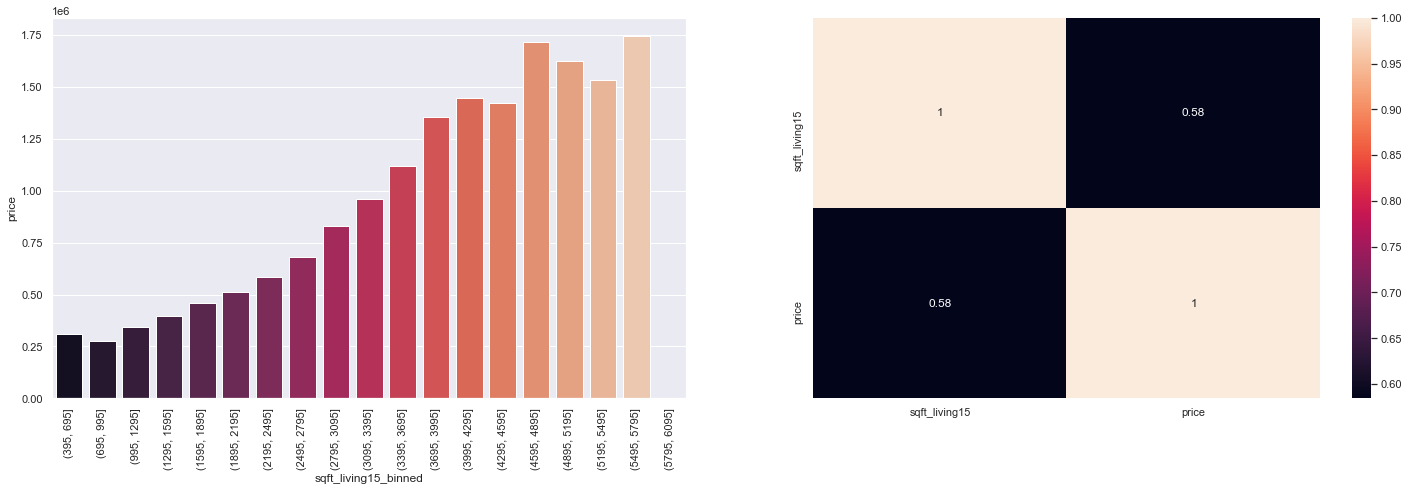

In [92]:
sns.set(rc={'figure.figsize':(25,7)})

plt.subplot (1,2,1)
aux1 = df5[['sqft_living15', 'price']]

bins = np.arange(395, 6395, 300)
aux1['sqft_living15_binned'] = pd.cut (aux1['sqft_living15'], bins = bins)
aux2 = aux1[['sqft_living15_binned', 'price']].groupby('sqft_living15_binned').mean().reset_index()
sns.barplot (x = 'sqft_living15_binned', y = 'price', data = aux2, palette = 'rocket');
plt.xticks(rotation = 90);


plt.subplot (1,2,2)
aux3 = df5[['sqft_living15', 'price']]
sns.heatmap(aux3.corr(method= 'pearson'), annot = True, cmap="rocket");

### H16: Houses with high profit are more expensive.
**FALSE.** Houses with prejudice are more expensive.

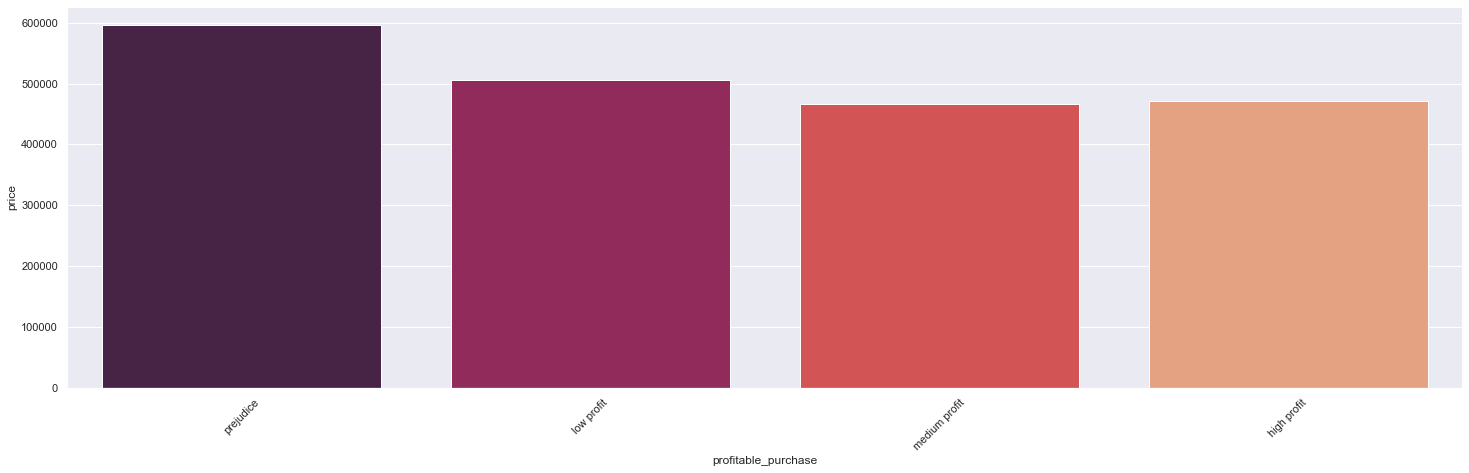

In [93]:
sns.set(rc={'figure.figsize':(25,7)})

aux1 = df5[['profitable_purchase', 'price']].groupby('profitable_purchase').mean().reset_index()
sns.barplot (x = 'profitable_purchase', y = 'price', data = aux1, palette = 'rocket', order = ['prejudice', 'low profit', 'medium profit', 'high profit']);
plt.xticks(rotation = 45);

### 5.2.1 Hypotheses resume

In [94]:
# display columns complete description
pd.set_option('display.max_colwidth', None)


# Hypothesis Summary dataframe
summary = pd.DataFrame({'Hypothesis':['Houses with higher conditions are more expensive.',
                                      'Houses built after 1955 are more expensive.',
                                      'Houses renovated in less time are more expensive.',
                                      'Houses with higher grades are more expensives.',
                                      'Houses with basement are more expensive.',
                                      'Houses with higher built area are more expensive.',
                                      'Houses with more bedrooms are more expensive.',
                                      'Houses with more bathrooms are more expensive.',
                                      'Houses with more floors are more expensive.',
                                      'Houses sold in the first 15 days of the month are more expensive.',
                                      'Houses sold in the first 3 months of the year are more expensive.',
                                      'Houses are more expensive in Seattle City.',
                                      'Houses with lake view are more expensive.',
                                      'Houses a better view grade are more expensive.',
                                      'Houses near other houses with high sqft living are more expensive.',
                                      'Houses with high profit are more expensive.'],
                        'True / False':['True', 'False', 'True', 'True', 'True', 'True', 'False', 'True', 'True',
                                        'False','False','False','True', 'True','True', 'False'], 
                        'Relevance':['Low', 'Low', 'Medium', 'High', 'Medium', 'High', 'Medium', 'High', 'Medium', 'Low',
                                     'Low','High','High','Medium','High','High']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
summary

Hypothesis  \
1                    Houses with higher conditions are more expensive.   
2                          Houses built after 1955 are more expensive.   
3                    Houses renovated in less time are more expensive.   
4                       Houses with higher grades are more expensives.   
5                             Houses with basement are more expensive.   
6                    Houses with higher built area are more expensive.   
7                        Houses with more bedrooms are more expensive.   
8                       Houses with more bathrooms are more expensive.   
9                          Houses with more floors are more expensive.   
10   Houses sold in the first 15 days of the month are more expensive.   
11   Houses sold in the first 3 months of the year are more expensive.   
12                          Houses are more expensive in Seattle City.   
13                           Houses with lake view are more expensive.   
14                      Houses a better view grade are more expensive.   
15  Houses near other houses with high sqft living are more expensive.   
16                         Houses with high profit are more expensive.   

   True / False Relevance  
1          True       Low  
2         False       Low  
3          True    Medium  
4          True      High  
5          True    Medium  
6          True      High  
7         False    Medium  
8          True      High  
9          True    Medium  
10        False       Low  
11        False       Low  
12        False      High  
13         True      High  
14         True    Medium  
15         True      High  
16        False      High

## 5.3 Multivariate Analysis

### 5.3.1 Numerical Attributes

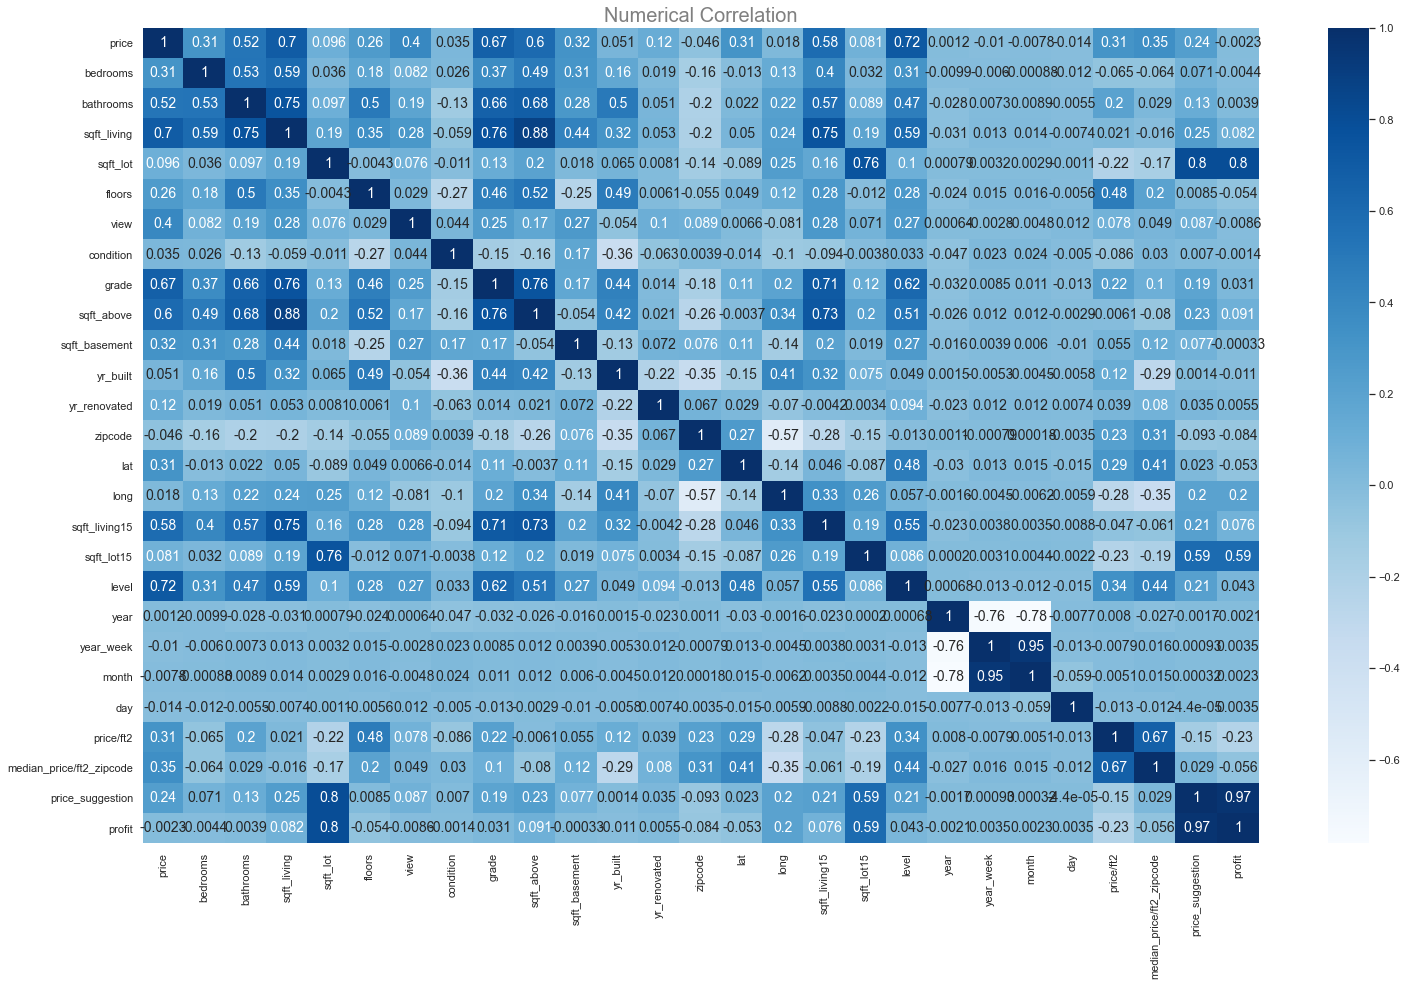

In [95]:
fig = plt.figure(figsize = (25,15))
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Numerical Correlation", size=20, color='gray');

### 5.3.2 Binary x Numerical Attributes

In [96]:
num_attributes.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'level', 'year', 'year_week', 'month', 'day', 'price/ft2',
       'median_price/ft2_zipcode', 'price_suggestion', 'profit'],
      dtype='object')

In [97]:
bin_attributes.columns

Index(['waterfront', 'decision'], dtype='object')

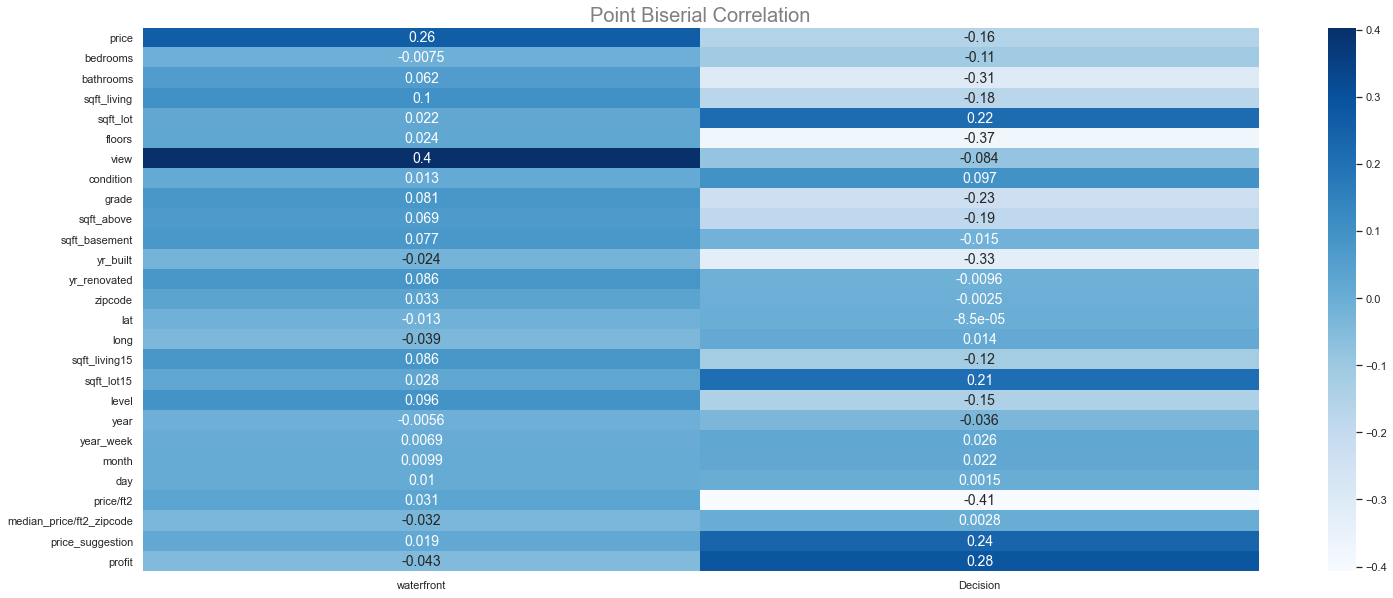

In [98]:
x1 = pointbiserialr(bin_attributes['waterfront'], num_attributes['price'])[0]
x2 = pointbiserialr(bin_attributes['waterfront'], num_attributes['bedrooms'])[0]
x3 = pointbiserialr(bin_attributes['waterfront'], num_attributes['bathrooms'])[0]
x4 = pointbiserialr(bin_attributes['waterfront'], num_attributes['sqft_living'])[0]
x5 = pointbiserialr(bin_attributes['waterfront'], num_attributes['sqft_lot'])[0]
x6 = pointbiserialr(bin_attributes['waterfront'], num_attributes['floors'])[0]
x7 = pointbiserialr(bin_attributes['waterfront'], num_attributes['view'])[0]
x8 = pointbiserialr(bin_attributes['waterfront'], num_attributes['condition'])[0]
x9 = pointbiserialr(bin_attributes['waterfront'], num_attributes['grade'])[0]
x10 = pointbiserialr(bin_attributes['waterfront'], num_attributes['sqft_above'])[0]
x11 = pointbiserialr(bin_attributes['waterfront'], num_attributes['sqft_basement'])[0]
x12 = pointbiserialr(bin_attributes['waterfront'], num_attributes['yr_built'])[0]
x13 = pointbiserialr(bin_attributes['waterfront'], num_attributes['yr_renovated'])[0]
x14 = pointbiserialr(bin_attributes['waterfront'], num_attributes['zipcode'])[0]
x15 = pointbiserialr(bin_attributes['waterfront'], num_attributes['lat'])[0]
x16 = pointbiserialr(bin_attributes['waterfront'], num_attributes['long'])[0]
x17 = pointbiserialr(bin_attributes['waterfront'], num_attributes['sqft_living15'])[0]
x18 = pointbiserialr(bin_attributes['waterfront'], num_attributes['sqft_lot15'])[0]
x19 = pointbiserialr(bin_attributes['waterfront'], num_attributes['level'])[0]
x20 = pointbiserialr(bin_attributes['waterfront'], num_attributes['year'])[0]
x21 = pointbiserialr(bin_attributes['waterfront'], num_attributes['year_week'])[0]
x22 = pointbiserialr(bin_attributes['waterfront'], num_attributes['month'])[0]
x23 = pointbiserialr(bin_attributes['waterfront'], num_attributes['day'])[0]
x24 = pointbiserialr(bin_attributes['waterfront'], num_attributes['price/ft2'])[0]
x25 = pointbiserialr(bin_attributes['waterfront'], num_attributes['median_price/ft2_zipcode'])[0]
x26 = pointbiserialr(bin_attributes['waterfront'], num_attributes['price_suggestion'])[0]
x27 = pointbiserialr(bin_attributes['waterfront'], num_attributes['profit'])[0]

x28 = pointbiserialr(bin_attributes['decision'], num_attributes['price'])[0]
x29 = pointbiserialr(bin_attributes['decision'], num_attributes['bedrooms'])[0]
x30 = pointbiserialr(bin_attributes['decision'], num_attributes['bathrooms'])[0]
x31 = pointbiserialr(bin_attributes['decision'], num_attributes['sqft_living'])[0]
x32 = pointbiserialr(bin_attributes['decision'], num_attributes['sqft_lot'])[0]
x33 = pointbiserialr(bin_attributes['decision'], num_attributes['floors'])[0]
x34 = pointbiserialr(bin_attributes['decision'], num_attributes['view'])[0]
x35 = pointbiserialr(bin_attributes['decision'], num_attributes['condition'])[0]
x36 = pointbiserialr(bin_attributes['decision'], num_attributes['grade'])[0]
x37 = pointbiserialr(bin_attributes['decision'], num_attributes['sqft_above'])[0]
x38 = pointbiserialr(bin_attributes['decision'], num_attributes['sqft_basement'])[0]
x39 = pointbiserialr(bin_attributes['decision'], num_attributes['yr_built'])[0]
x40 = pointbiserialr(bin_attributes['decision'], num_attributes['yr_renovated'])[0]
x41 = pointbiserialr(bin_attributes['decision'], num_attributes['zipcode'])[0]
x42 = pointbiserialr(bin_attributes['decision'], num_attributes['lat'])[0]
x43 = pointbiserialr(bin_attributes['decision'], num_attributes['long'])[0]
x44 = pointbiserialr(bin_attributes['decision'], num_attributes['sqft_living15'])[0]
x45 = pointbiserialr(bin_attributes['decision'], num_attributes['sqft_lot15'])[0]
x46 = pointbiserialr(bin_attributes['decision'], num_attributes['level'])[0]
x47 = pointbiserialr(bin_attributes['decision'], num_attributes['year'])[0]
x48 = pointbiserialr(bin_attributes['decision'], num_attributes['year_week'])[0]
x49 = pointbiserialr(bin_attributes['decision'], num_attributes['month'])[0]
x50 = pointbiserialr(bin_attributes['decision'], num_attributes['day'])[0]
x51 = pointbiserialr(bin_attributes['decision'], num_attributes['price/ft2'])[0]
x52 = pointbiserialr(bin_attributes['decision'], num_attributes['median_price/ft2_zipcode'])[0]
x53 = pointbiserialr(bin_attributes['decision'], num_attributes['price_suggestion'])[0]
x54 = pointbiserialr(bin_attributes['decision'], num_attributes['profit'])[0]

# Final dataset
d = pd.DataFrame({'waterfront':[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, 
                                x14, x15, x16, x17, x18, x19, x20, x21, x22, x23, x24,
                                x25, x26, x27],
                  'Decision':[x28, x29, x30, x31, x32, x33, x34, x35, x36, x37, x38, x39, x40, 
                                x41, x42, x43, x44, x45, x46, x47, x48, x49, x50, x51,
                                x52, x53, x54]})

# Sets the index equal to columns
d = d.set_index(num_attributes.columns)

fig = plt.figure(figsize = (25,10))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Point Biserial Correlation", size=20, color='gray');

### 5.3.3 Categorical Attributes

In [99]:
# Only categorical data
a = df5.select_dtypes( include = 'object')

In [100]:
a.columns

Index(['standard', 'profitable_purchase', 'road', 'house_number', 'city'], dtype='object')

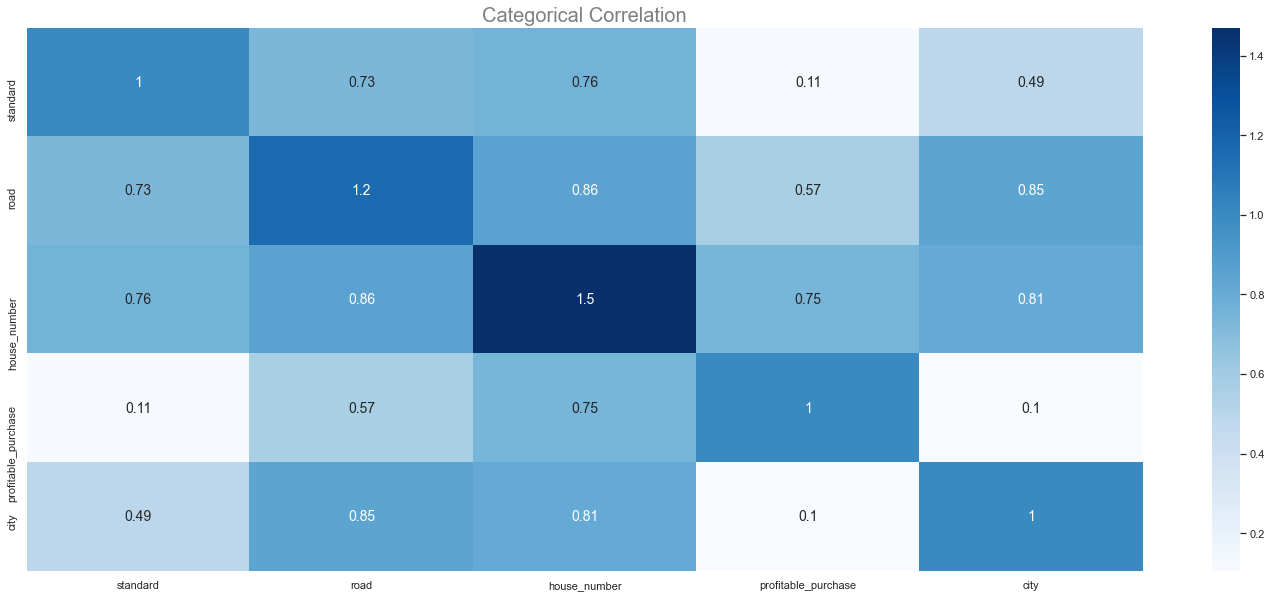

In [101]:
# Calculate cramer v

a1 = cramer_v( a['standard'], a['standard'] )
a2 = cramer_v( a['standard'], a['road'] )
a3 = cramer_v( a['standard'], a['house_number'] )
a4 = cramer_v( a['standard'], a['profitable_purchase'] )
a5 = cramer_v( a['standard'], a['city'] )

a6 = cramer_v( a['road'], a['standard'] )
a7 = cramer_v( a['road'], a['road'] )
a8 = cramer_v( a['road'], a['house_number'] )
a9 = cramer_v( a['road'], a['profitable_purchase'] )
a10 = cramer_v( a['road'], a['city'] )

a11 = cramer_v( a['house_number'], a['standard'] )
a12 = cramer_v( a['house_number'], a['road'] )
a13 = cramer_v( a['house_number'], a['house_number'] )
a14 = cramer_v( a['house_number'], a['profitable_purchase'] )
a15 = cramer_v( a['house_number'], a['city'] )

a16 = cramer_v( a['profitable_purchase'], a['standard'] )
a17 = cramer_v( a['profitable_purchase'], a['road'] )
a18 = cramer_v( a['profitable_purchase'], a['house_number'] )
a19 = cramer_v( a['profitable_purchase'], a['profitable_purchase'] )
a20 = cramer_v( a['profitable_purchase'], a['city'] )

a21 = cramer_v( a['city'], a['standard'] )
a22 = cramer_v( a['city'], a['road'] )
a23 = cramer_v( a['city'], a['house_number'] )
a24 = cramer_v( a['city'], a['profitable_purchase'] )
a25 = cramer_v( a['city'], a['city'] )


# Final dataset
d = pd.DataFrame( {'standard': [a1, a2, a3, a4, a5],
                   'road': [a6, a7, a8, a9, a10],
                   'house_number': [a11, a12, a13, a14, a15],
                   'profitable_purchase': [a16, a17, a18, a19, a20],
                   'city': [a21, a22, a23, a24, a25]})

    
d = d.set_index(d.columns)

fig = plt.figure(figsize = (25,10))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Categorical Correlation", size=20, color='gray');

# 6.0 FINAL ANALYSIS

In [117]:
df6 = df5.copy()

## 6.1 Rewriting Features
Let's rewrite some features based on the results obtained from data analysis.

In [133]:
# Sales price suggestion
df6['price_suggestion'] = df6[['waterfront', 'sqft_lot', 'median_price/ft2_zipcode', 'condition']].apply(lambda x: (x['median_price/ft2_zipcode']*x['sqft_lot']) if (x['condition']>= 3) & (x['waterfront']==0) 
                                                                                                         else ((x['median_price/ft2_zipcode']*x['sqft_lot'])*3) if (x['condition']>= 3) & (x['waterfront']==1)
                                                                                                         else ((x['median_price/ft2_zipcode']*x['sqft_lot'])*0.8) if (x['condition']< 3) & (x['waterfront']==0)
                                                                                                         else ((x['median_price/ft2_zipcode']*x['sqft_lot'])*0.8*3), axis = 1)
# decision: buy or not buy
df6['decision'] = df6[['profit']].apply(lambda x: 1 if (x['profit']>0) else 0, axis = 1)


# Sales profit
df6['profit'] = df6['price_suggestion'] - df6['price']

# Profitable purchase: 
df6['profitable_purchase'] = df6[['profit', 'price']].apply(lambda x: 'prejudice' if (x['profit']< 0) else 'low profit' 
                                                              if x['profit']< (x['price']*0.25) 
                                                              else 'medium profit' if  (x['price']*0.25) <= x['profit'] < (x['price']*0.5) 
                                                              else 'high profit', axis = 1)

## 6.2 Features Selection

In [129]:
df6.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price/ft2',
       'median_price/ft2_zipcode', 'decision', 'price_suggestion', 'profit',
       'profitable_purchase', 'road', 'house_number', 'city'],
      dtype='object')

In [122]:
df6 = df6.drop(['standard', 'year', 'year_week', 'month', 'day', 'level'], axis=1)

# 7.0 MAP

In [102]:
df7 = df5.copy()

In [103]:
houses = df7[['id', 'lat', 'long', 'price', 'level']].copy()

fig = px.scatter_mapbox(houses, lat ='lat', lon = 'long', color ='level', size = 'price', 
                        color_continuous_scale = px.colors.cyclical.IceFire,
                        size_max = 15, zoom = 10)
fig.update_layout( mapbox_style = 'open-street-map')
fig.update_layout( height = 600, margin = {'r':0, 't':0, 'l':0, 'b':0})
fig.show()

### 7.1 Adding filter options so the person can do their own analysis:
- Filter properties with a water view or not.
- Filter properties down to a certain price value.

In [104]:
style = {'description_width': 'initial'}

# Iterative buttons
price_limit = widgets.IntSlider( value = 540000, min = 75000, max = 77000000, step = 1,
                                 description = 'Maximum Price', disable = False, style = style)  

df7['is_waterfront'] = df7['waterfront'].apply( lambda x: 'yes' if x == 1 else 'no')

waterfront_bar = widgets.Dropdown(options = df7['is_waterfront'].unique().tolist(),
                                  value = 'yes', description = 'Water View', disable = False)


In [105]:
widgets.interactive(update_map, df = fixed(df7), waterfront = waterfront_bar, limit = price_limit)

interactive(children=(Dropdown(description='Water View', index=1, options=('no', 'yes'), value='yes'), IntSlid…

# 8.0 BUSINESS PERFORMANCE

In [142]:
df8 = df6.copy()

<AxesSubplot:xlabel='date', ylabel='price_suggestion'>

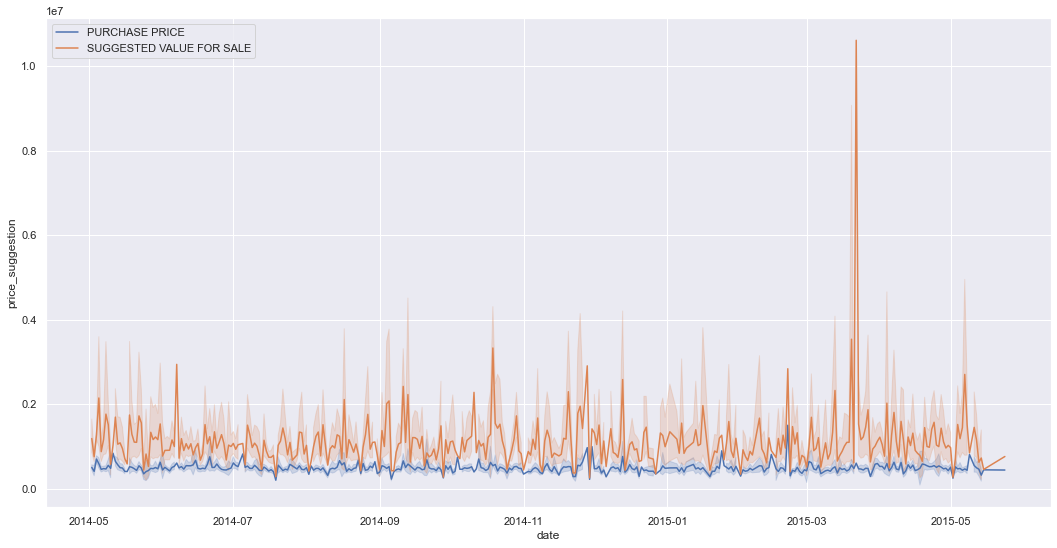

In [139]:
aux1 = df8[df8['decision']==1][['price', 'price_suggestion', 'profit', 'date']]

fig = plt.figure(figsize = (18,9))

sns.lineplot(x="date", y="price", data=aux1, label="PURCHASE PRICE")
sns.lineplot(x="date", y="price_suggestion", data=aux1, label="SUGGESTED VALUE FOR SALE")

<AxesSubplot:xlabel='date', ylabel='price_suggestion'>

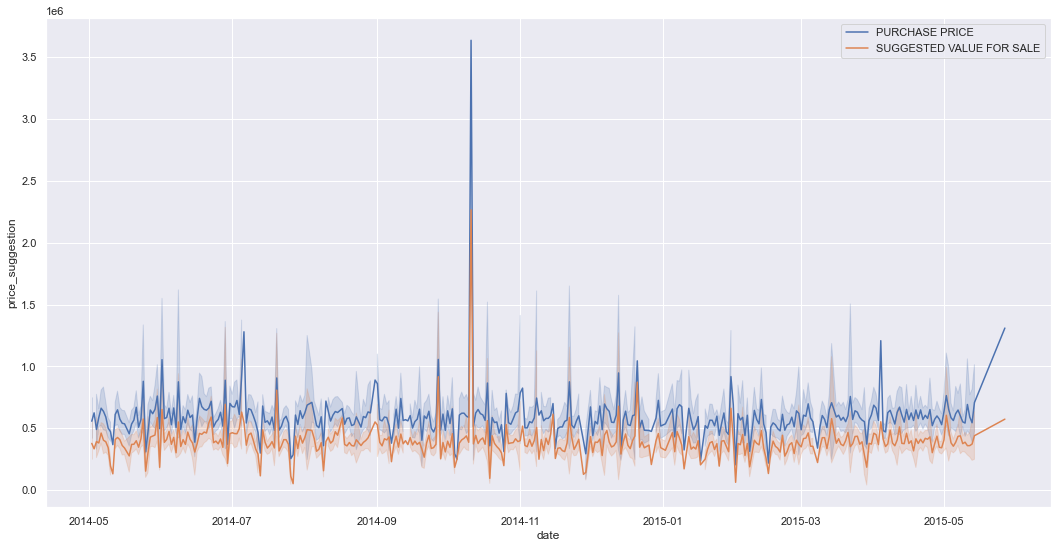

In [141]:
aux1 = df8[df8['decision']==0][['price', 'price_suggestion', 'profit', 'date']]

fig = plt.figure(figsize = (18,9))

sns.lineplot(x="date", y="price", data=aux1, label="PURCHASE PRICE")
sns.lineplot(x="date", y="price_suggestion", data=aux1, label="SUGGESTED VALUE FOR SALE")

In [137]:
total_profit = df8[df8['decision']==1]['profit'].sum()


6993403564.677715